## DE 2 vs. MSIS-90 / NRLMSIS-00 / RMIT-SERC / DTM2013 Analysis

Copy of the 'DE2_and_All_Models_Analysis' notebook looking at the effect of changing the hmF2 model used in the IRI (ion contribution of SERC model).

The original RMIT implementation used the SHU-2015 model (df_RMIT), while here we also investigate the use of AMTB-2013 (df_RMIT2).

In this notebook I will also try to finalise all the analysis of all 4 models against the DE2 data, ensuring I can offload the final report to Rob

### 2019-10-15 / 2019-10-16 / 2019-10-17 / 2019-10-18 / 2019-10-21 / 2019-11-06

In [1]:
# import packages:
import numpy as np 
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as sig
import copy
from IPython.display import HTML,Markdown,display

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The code for this Jupyter notebook has been hidden.
To switch the code on/off, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
N00_comp_path = Path(Path.cwd(),'N00_DE2_Comparison_Results_All2.csv')
df_N00 = pd.read_csv(N00_comp_path) # Introduce Pandas dataframe of N00 model results

RMIT_comp_path = Path(Path.cwd(),'RMIT_DE2_Comparison_Results_All2.csv')
df_RMIT = pd.read_csv(RMIT_comp_path) # Introduce Pandas dataframe of RMIT model results

RMIT2_comp_path = Path(Path.cwd(),'RMIT_DE2_Comparison_Results_all_AMTB.csv')
df_RMIT2 = pd.read_csv(RMIT2_comp_path) # Introduce Pandas dataframe of RMIT model results

M90_comp_path = Path(Path.cwd(),'MS90_DE2_Comparison_Results_All2.csv')
df_M90 = pd.read_csv(M90_comp_path) # Introduce Pandas dataframe of MSIS-90 model results

D13_comp_path = Path(Path.cwd(),'DTM13_F107_DE2_Comparison_Results_All2.csv')
df_D13 = pd.read_csv(D13_comp_path) # Introduce Pandas dataframe of RMIT model results

In [4]:
# To ensure a fair comparison, only consider data with altitudes above 300 km
df_RMIT_300 = df_RMIT[df_RMIT['Altitude'] > 300.0]
df_RMIT2_300 = df_RMIT2[df_RMIT['Altitude'] > 300.0]
df_N00_300 = df_N00[df_RMIT['Altitude'] > 300.0]
df_M90_300 = df_M90[df_RMIT['Altitude'] > 300.0]
df_D13_300 = df_D13[df_RMIT['Altitude'] > 300.0]

In [5]:
# For missing neutrals data, need to only include cases where neutrals are greater than at least twice the ion measurements
df_RMIT_new = df_RMIT_300[df_RMIT_300['Neutral_Mass_Den_measure'] > df_RMIT_300['Ion_Mass_Den_measure']*2]
df_RMIT2_new = df_RMIT2_300[df_RMIT2_300['Neutral_Mass_Den_measure'] > df_RMIT2_300['Ion_Mass_Den_measure']*2]
df_N00_new = df_N00_300[df_RMIT_300['Neutral_Mass_Den_measure'] > df_RMIT_300['Ion_Mass_Den_measure']*2]
df_M90_new = df_M90_300[df_RMIT_300['Neutral_Mass_Den_measure'] > df_RMIT_300['Ion_Mass_Den_measure']*2]
df_D13_new = df_D13_300[df_RMIT_300['Neutral_Mass_Den_measure'] > df_RMIT_300['Ion_Mass_Den_measure']*2]

In [6]:
# Introduce a new column in dataframe that handles larger and smaller estimates of the density better than differences.
# This is based on the log10 of the ratio (Model/Measurement)
df_RMIT_new = df_RMIT_new.assign(log_Ratio_model_measure = np.log10(df_RMIT_new['Total_Mass_Den_model']/df_RMIT_new['Total_Mass_Den_measure']))
df_RMIT2_new = df_RMIT2_new.assign(log_Ratio_model_measure = np.log10(df_RMIT2_new['Total_Mass_Den_model']/df_RMIT2_new['Total_Mass_Den_measure']))
df_N00_new = df_N00_new.assign(log_Ratio_model_measure = np.log10(df_N00_new['Total_Mass_Den_model']/df_N00_new['Total_Mass_Den_measure']))
df_M90_new = df_M90_new.assign(log_Ratio_model_measure = np.log10(df_M90_new['Neutral_Mass_Den_model']/df_RMIT_new['Total_Mass_Den_measure']))
df_D13_new = df_D13_new.assign(log_Ratio_model_measure = np.log10(df_D13_new['Total_Mass_Den_model']/df_D13_new['Total_Mass_Den_measure']))

In [7]:
# Function to remove peaks/spikes and troughs:
def clean_spikes(df,col):
    pk_idxs, properties = sig.find_peaks(df[col],prominence=min(df[col]))
    df = df.drop(df.iloc[pk_idxs].index, axis=0)
    
    df[col] = 1/df[col]
    pk_idxs, properties = sig.find_peaks(df[col],prominence=min(df[col]))
    df = df.drop(df.iloc[pk_idxs].index, axis=0)
    
    df[col] = 1/df[col]
    return df

# Clean data:
def clean_twice(df,col):
    # Clean RMIT once
    df_clean = copy.deepcopy(df)
    df_clean = clean_spikes(df_clean,col)
    # Clean RMIT twice
    df_clean = clean_spikes(df_clean,col)
    return df_clean

In [8]:
df_RMIT_clean = clean_twice(df_RMIT_new,'Total_Mass_Den_measure')
idxs = df_RMIT_clean.index
df_RMIT2_clean = df_RMIT2_new.loc[idxs]
df_N00_clean = df_N00_new.loc[idxs]
df_M90_clean = df_M90_new.loc[idxs]
df_D13_clean = df_D13_new.loc[idxs]

# Identify problematic days based on the absolute size of the log ratio (positive or negative):
cond = (df_RMIT_clean['log_Ratio_model_measure'] > 1.7) | (df_RMIT_clean['log_Ratio_model_measure'] < -1.7)

doys=[d for d,y in df_RMIT_clean[cond][['DOY','Year']].values]
years=[y for d,y in df_RMIT_clean[cond][['DOY','Year']].values]

prob_days = []
for d,y in zip(doys,years):
    if (d,y) in prob_days:
        pass 
    else:
        prob_days.append((d,y))

# Day 231 is a problematic day, where sensor data is incorrect so let's drop values beyond 0600 UT:
day,year = prob_days[0]
drop_cond = (
          (df_RMIT_clean['DOY'] == day) 
        & (df_RMIT_clean['Year'] == year) 
        & (df_RMIT_clean['Decimal_Hr'] > 6)
        )
df_RMIT_clean = df_RMIT_clean.drop(df_RMIT_clean[drop_cond].index, axis = 0)

# Remove problematic areas from other days too:
day,year = prob_days[1]
drop_cond = (
          (df_RMIT_clean['DOY'] == day) 
        & (df_RMIT_clean['Year'] == year) 
        & (df_RMIT_clean['Decimal_Hr'] > 10.27) 
        & (df_RMIT_clean['Decimal_Hr'] < 15.79)
       )
df_RMIT_clean = df_RMIT_clean.drop(df_RMIT_clean[drop_cond].index, axis = 0)

day,year = prob_days[2]
cond = (
          (df_RMIT_clean['DOY'] == day) 
        & (df_RMIT_clean['Year'] == year) 
        & (df_RMIT_clean['Decimal_Hr'] > 3.76) 
        & (df_RMIT_clean['Decimal_Hr'] < 4)
       )
df_RMIT_clean = df_RMIT_clean.drop(df_RMIT_clean[cond].index, axis = 0)

day,year = prob_days[3]
cond = (
          (df_RMIT_clean['DOY'] == day) 
        & (df_RMIT_clean['Year'] == year) 
        & (df_RMIT_clean['Decimal_Hr'] > 18.765) 
        & (df_RMIT_clean['Decimal_Hr'] < 18.84)
       )
df_RMIT_clean = df_RMIT_clean.drop(df_RMIT_clean[cond].index, axis = 0)

day,year = prob_days[4]
cond = (
          (df_RMIT_clean['DOY'] == day) 
        & (df_RMIT_clean['Year'] == year) 
        & (df_RMIT_clean['Decimal_Hr'] > 10) 
       )
df_RMIT_clean = df_RMIT_clean.drop(df_RMIT_clean[cond].index, axis = 0)

day,year = prob_days[5]
cond = (
          (df_RMIT_clean['DOY'] == day) 
        & (df_RMIT_clean['Year'] == year) 
        & (df_RMIT_clean['Decimal_Hr'] < 1) 
       )
df_RMIT_clean = df_RMIT_clean.drop(df_RMIT_clean[cond].index, axis=0)

# As looking at individual cases took much too long, I decided to remove all data points more than 30x greater/smaller:
cond = (df_RMIT_clean['log_Ratio_model_measure'] > 1.48) | (df_RMIT_clean['log_Ratio_model_measure'] < -1.48)
df_RMIT_clean = df_RMIT_clean.drop(df_RMIT_clean[cond].index,axis=0)

# Use the indexes of the RMIT_clean dataframe to ensure the other models contain the same points:
idxs = df_RMIT_clean.index
df_RMIT2_clean = df_RMIT2_clean.loc[idxs]
df_N00_clean = df_N00_clean.loc[idxs]
df_M90_clean = df_M90_clean.loc[idxs]
df_D13_clean = df_D13_clean.loc[idxs]

In [9]:
# Do a similar clean for the other models (nothing above or below 1.48 or -1.48, respectively)
def eliminate_30x(df_elim, df1, df2, df3, df4):
    cond = (df_elim['log_Ratio_model_measure'] > 1.48) | (df_elim['log_Ratio_model_measure'] < -1.48)
    df_elim = df_elim.drop(df_elim[cond].index,axis=0)
    
    idxs = df_elim.index
    df1 = df1.loc[idxs]
    df2 = df2.loc[idxs]
    df3 = df3.loc[idxs]
    df4 = df4.loc[idxs]
    return df_elim, df1, df2, df3, df4

In [10]:
df_N00_clean, df_RMIT_clean, df_D13_clean, df_M90_clean, df_RMIT2_clean = eliminate_30x(df_N00_clean, df_RMIT_clean, df_D13_clean, df_M90_clean, df_RMIT2_clean)
df_M90_clean, df_N00_clean, df_RMIT_clean, df_D13_clean, df_RMIT2_clean = eliminate_30x(df_M90_clean, df_N00_clean, df_RMIT_clean, df_D13_clean, df_RMIT2_clean)
df_D13_clean, df_M90_clean, df_N00_clean, df_RMIT_clean, df_RMIT2_clean = eliminate_30x(df_D13_clean, df_M90_clean, df_N00_clean, df_RMIT_clean, df_RMIT2_clean)
df_RMIT2_clean, df_D13_clean, df_M90_clean, df_N00_clean, df_RMIT_clean = eliminate_30x(df_RMIT2_clean, df_D13_clean, df_M90_clean, df_N00_clean, df_RMIT_clean)

In [11]:
# Introduce Local Solar time column and ensure no values are above 24 or below 0 (in that case, shift to appropriate time):
df_RMIT_clean['Solar_Local_Time'] = df_RMIT_clean['Decimal_Hr'] + (df_RMIT_clean['Longitude']/(np.pi/12))

over_mask = (df_RMIT_clean['Solar_Local_Time'] > 24)
under_mask = (df_RMIT_clean['Solar_Local_Time'] < 0)

df_RMIT_clean.loc[over_mask, 'Solar_Local_Time'] = df_RMIT_clean.loc[over_mask, 'Solar_Local_Time'] - 24
df_RMIT_clean.loc[under_mask, 'Solar_Local_Time'] = df_RMIT_clean.loc[under_mask, 'Solar_Local_Time'] + 24

df_RMIT2_clean['Solar_Local_Time'] = df_RMIT_clean['Solar_Local_Time']
df_N00_clean['Solar_Local_Time'] = df_RMIT_clean['Solar_Local_Time']
df_M90_clean['Solar_Local_Time'] = df_RMIT_clean['Solar_Local_Time']
df_D13_clean['Solar_Local_Time'] = df_RMIT_clean['Solar_Local_Time']

In [12]:
# Prepare examples for showcase in Mardown:
df_quick_1 = copy.deepcopy(df_RMIT_new.loc[(df_RMIT_new['DOY'] == 231) & (df_RMIT_new['Year'] == 1981)])
df_quick_2 = copy.deepcopy(df_RMIT_new.loc[(df_RMIT_new['DOY'] == 269) & (df_RMIT_new['Year'] == 1981)])

# Clean twice
df_quick_1 = clean_spikes(df_quick_1,'Total_Mass_Den_measure')
df_quick_1 = clean_spikes(df_quick_1,'Total_Mass_Den_measure')

df_quick_2 = clean_spikes(df_quick_2,'Total_Mass_Den_measure')
df_quick_2 = clean_spikes(df_quick_2,'Total_Mass_Den_measure')

df_inspect = df_RMIT_new.loc[(df_RMIT_new['DOY'] == 258) & 
                             (df_RMIT_new['Year'] == 1982) & 
                             (df_RMIT_new['Decimal_Hr'] > 17) & 
                             (df_RMIT_new['Decimal_Hr'] < 18)]

df_rmv2 = clean_spikes(df_inspect,'Total_Mass_Den_measure')
df_rmv3 = clean_spikes(df_rmv2,'Total_Mass_Den_measure')

In [13]:
log_var = 'log_Ratio_model_measure'
cond_a = (df_RMIT_clean['Altitude'] > 0.0)
lo_alt = (df_RMIT_clean['Altitude'] < 500.0)
hi_alt = (df_RMIT_clean['Altitude'] > 500.0)

def calc_mean(df,cond,var):
    return (10**((df[cond][var]).mean())-1)*100

def calc_std(df,cond,var):
    return (10**((df[cond][var])).std()-1)*100

In [14]:
def create_mean_std_table5(df1, df2, df3, df4, df5, df1_name, df2_name, df3_name, df4_name, df5_name, conditions, var, tab_name, pts_fl=True):
    if pts_fl:
        output = f"""
<table>
  <thead>
    <tr>
      <th>{tab_name}</th>
      <th>{df1_name}</th>
      <th>{df2_name}</th>
      <th>{df3_name}</th>
      <th>{df4_name}</th>
      <th>{df5_name}</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>{calc_mean(df1,(conditions),var):.3f} %</td>
      <td>{calc_mean(df2,(conditions),var):.3f} %</td>
      <td>{calc_mean(df3,(conditions),var):.3f} %</td>
      <td>{calc_mean(df4,(conditions),var):.3f} %</td>
      <td>{calc_mean(df5,(conditions),var):.3f} %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>{calc_std(df1,(conditions),var):.2f} %</td>
      <td>{calc_std(df2,(conditions),var):.2f} %</td>
      <td>{calc_std(df3,(conditions),var):.2f} %</td>
      <td>{calc_std(df4,(conditions),var):.2f} %</td>
      <td>{calc_std(df5,(conditions),var):.2f} %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>{len(df1[conditions][var])}</td>
      <td>{len(df2[conditions][var])}</td>
      <td>{len(df3[conditions][var])}</td>
      <td>{len(df4[conditions][var])}</td>
      <td>{len(df5[conditions][var])}</td>
    </tr>
  </tbody>
</table>
        """
    else:
        output = f"""
<table>
  <thead>
    <tr>
      <th>{tab_name}</th>
      <th>{df1_name}</th>
      <th>{df2_name}</th>
      <th>{df3_name}</th>
      <th>{df4_name}</th>
      <th>{df5_name}</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>{calc_mean(df1,(conditions),var):.3f} %</td>
      <td>{calc_mean(df2,(conditions),var):.3f} %</td>
      <td>{calc_mean(df3,(conditions),var):.3f} %</td>
      <td>{calc_mean(df4,(conditions),var):.3f} %</td>
      <td>{calc_mean(df5,(conditions),var):.3f} %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>{calc_std(df1,(conditions),var):.2f} %</td>
      <td>{calc_std(df2,(conditions),var):.2f} %</td>
      <td>{calc_std(df3,(conditions),var):.2f} %</td>
      <td>{calc_std(df4,(conditions),var):.2f} %</td>
      <td>{calc_std(df5,(conditions),var):.2f} %</td>
    </tr>
  </tbody>
</table>
        """
    return output

In [15]:
def create_mean_std_table(df1, df2, df3, df4, df1_name, df2_name, df3_name, df4_name, conditions, var, tab_name, pts_fl=True):
    if pts_fl:
        output = f"""
<table>
  <thead>
    <tr>
      <th align="center">{tab_name}</th>
      <th align="center">{df1_name}</th>
      <th align="center">{df2_name}</th>
      <th align="center">{df3_name}</th>
      <th align="center">{df4_name}</th>      
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>{calc_mean(df1,(conditions),var):.3f} %</td>
      <td>{calc_mean(df2,(conditions),var):.3f} %</td>
      <td>{calc_mean(df3,(conditions),var):.3f} %</td>
      <td>{calc_mean(df4,(conditions),var):.3f} %</td>      
    </tr>
    <tr>
      <td>Std.</td>
      <td>{calc_std(df1,(conditions),var):.2f} %</td>
      <td>{calc_std(df2,(conditions),var):.2f} %</td>
      <td>{calc_std(df3,(conditions),var):.2f} %</td>
      <td>{calc_std(df4,(conditions),var):.2f} %</td>      
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>{len(df1[conditions][var])}</td>
      <td>{len(df2[conditions][var])}</td>
      <td>{len(df3[conditions][var])}</td>
      <td>{len(df4[conditions][var])}</td>      
    </tr>
  </tbody>
</table>
        """
    else:
        output = f"""
<table>
  <thead>
    <tr>
      <th align="center">{tab_name}</th>
      <th align="center">{df1_name}</th>
      <th align="center">{df2_name}</th>
      <th align="center">{df3_name}</th>
      <th align="center">{df4_name}</th>      
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td align="center">{calc_mean(df1,(conditions),var):.3f} %</td>
      <td align="center">{calc_mean(df2,(conditions),var):.3f} %</td>
      <td align="center">{calc_mean(df3,(conditions),var):.3f} %</td>
      <td align="center">{calc_mean(df4,(conditions),var):.3f} %</td>      
    </tr>
    <tr>
      <td>Std.</td>
      <td align="center">{calc_std(df1,(conditions),var):.2f} %</td>
      <td align="center">{calc_std(df2,(conditions),var):.2f} %</td>
      <td align="center">{calc_std(df3,(conditions),var):.2f} %</td>
      <td align="center">{calc_std(df4,(conditions),var):.2f} %</td>      
    </tr>
  </tbody>
</table>
        """
    return output

# Dynamics Explorer (DE) 2 Mass Density Analysis
## Comparison of RMIT/SERC, MSISe-90, NRLMSIS-2000 and DTM2013 Models with In-Situ Measurements

This documents presents the comparison beween the in-situ measurements of atmospheric mass density (AMD) calculated from 
the DE 2 spacecraft's instrument results and AMD models. 
Specifically the Neutral Atmosphere Composition Spectrometer (NACS) was used to obtain values
for the neutral contribution while the Retarding Potential Analyzer (RPA) was used to obtain values for the ions. 

Three models, RMIT/SERC, NRLMSIS-2000 and DTM2013, produced total mass density results for a given altitude and latitude/longitude,
while MSISe-90 produces only gives values for the neutral particles. There are two versions of the RMIT/SERC model that are compared in this report, differing in the model for the height of the ionospheric F2 layer where electron density is a maximum (hmF2). Here, they have been labelled as 'RMIT' and 'RMIT-AMTB' for the Shubin, (2015) (https://doi.org/10.1016/j.asr.2015.05.029) and Altadill et. al., (2013) (https://doi.org/10.1016/j.asr.2012.11.018) models, respectively.
The coordinates from the spacecraft data were used for inputs in each model.  


### Point of Comparison - Ratio of Model to Measurement

The way I've ensured that both overestimates and underestimates of the density are taken into account when comparing the models
and the measurements is to use a log of the ratio of the model on the measurement labelled 'log_Ratio_model_measure' in the
dataframe. In other words, the model prediction is divided by the measurement value and the log base 10 of this ratio is what
is used as a point of comparison between the model of interest and the measurement:

$$ comp = \log_{10}\left(\frac{pred}{obs}\right) $$


### Data Cleaning Prcoess

After investigating this data, it was clear that a lot of the points were much too high or too low (orders of magnitude) 
as compared to the model estimates for the same altitude, longitude and latitude. One reason for this was spurious spikes or
dips in the measurements in otherwise smooth transitions as the spacecraft orbited and changed altitude. Therefore, I wrote

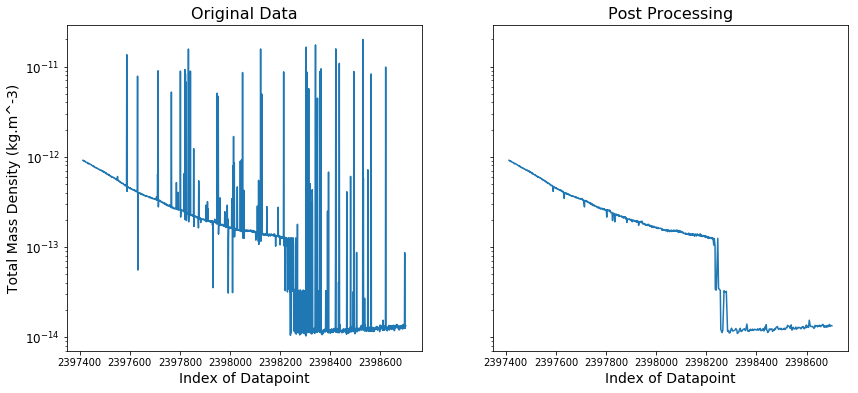

In [16]:
fig_pk,ax_pk = plt.subplots(1,2,figsize=(14,6),sharey=True)
ax_pk[1].set_yscale('log')
ax_pk[0].plot(df_inspect['Total_Mass_Den_measure'])
ax_pk[0].set_title('Original Data', fontsize=16)
ax_pk[0].set_xlabel('Index of Datapoint', fontsize=14)
ax_pk[0].set_ylabel('Total Mass Density (kg.m^-3)', fontsize=14)

ax_pk[1].plot(df_rmv3['Total_Mass_Den_measure'])
ax_pk[1].set_title('Post Processing', fontsize=16)
ax_pk[1].set_xlabel('Index of Datapoint', fontsize=14)
ax_pk[0].tick_params(axis='y',labelsize = 12)

plt.show(fig_pk)
plt.close(fig_pk)

Next, certain data series were an order of magnitude larger or smaller than surrounding data. There were a number of examples
of this including the two below:

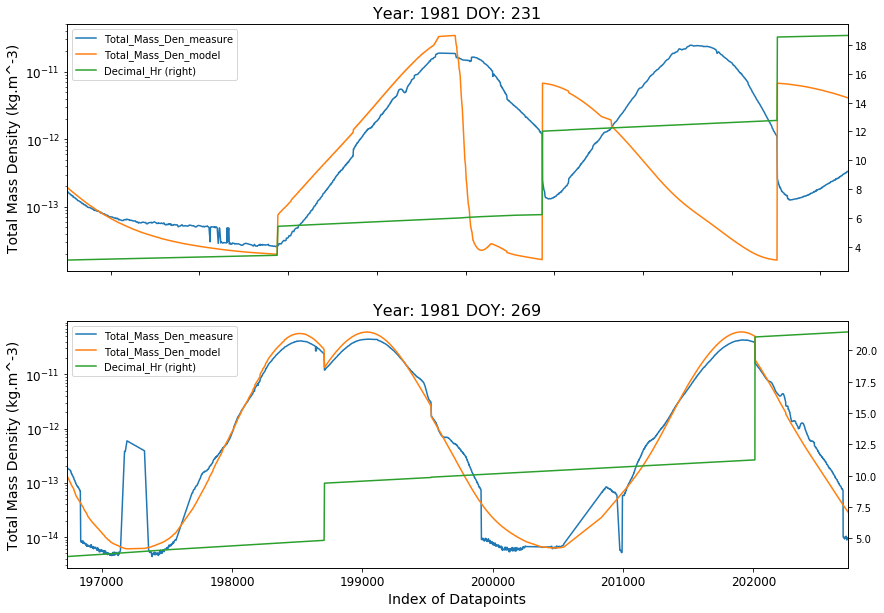

In [17]:
day = 269
year = 1981
fig_eg,ax_eg = plt.subplots(2,1,figsize=(14,10))
df_quick_1.plot(
    y=['Total_Mass_Den_measure','Total_Mass_Den_model'],
    logy=True,
    ax=ax_eg[0])
df_quick_1.Decimal_Hr.plot(
    secondary_y=True,
    ax=ax_eg[0],
    legend=True)
df_quick_2.plot(
    y=['Total_Mass_Den_measure','Total_Mass_Den_model'],
    logy=True,
    ax=ax_eg[1])
df_quick_2.Decimal_Hr.plot(
    secondary_y=True,
    legend=True,
    ax=ax_eg[1])
ax_eg[0].set_ylabel('Total Mass Density (kg.m^-3)', fontsize=14)
ax_eg[1].set_ylabel('Total Mass Density (kg.m^-3)', fontsize=14)
ax_eg[0].set_xlabel('Index of Datapoints', fontsize=14)
ax_eg[1].set_xlabel('Index of Datapoints', fontsize=14)
ax_eg[0].set_title(f'Year: 1981 DOY: 231', fontsize=16)
ax_eg[1].set_title(f'Year: {year} DOY: {day}', fontsize=16)
ax_eg[0].tick_params(axis='both',labelsize = 12)
ax_eg[1].tick_params(axis='both',labelsize = 12)
plt.show(fig_eg)
plt.close(fig_eg)

In the top case (which is the worst perfoming day in the entire dataset) the data is inverted compared to the model results
from about 0600 UT onward.  I investigated whether such a dramatic decrease could be possible in altitude / density 
measurements and concluded that instrumentation error must be the cause. In this specific case, I have ignored all data beyond
0600 UT.

In the bottom case we can see a large flat peak rise up from a low mass density floor. This was at a high altitude, and the
documentation to the instruments does state that measurements above 500 km are less accurate than those below 500 km. Again,
I have predicted this is due to some instrumentation error and have removed this peak from the data. 
There are dozens of examples of these flat peaks/troughs in the data and after removing a number of them, I have, for the
sake of time, just automatically removed all data beyond 30 times the value predicted by the RMIT model. This 30x removal was
also done for the MSIS-90, NRLMSIS-2000 and DTM2013 models.


### Data Comparison

To compare the models against the DE2 measurement, I calculated the mean of the log(ratio) to determine the proximity of 
the model to the measurements and also the standard deviation to determine the variablility about the mean results.

Converting this back to a more intuitive number, I've raised these statistics to the power 10 and subtracted 1, expressing
the final result as a percetange. This is the percentage away from the measurement, 0.0 % indicates perfect reproduction in the
case of the mean, and no variability in the case of the standard deviation. 

$$ percentage = (10^{comp} - 1) \times 100 \% $$

A positive percentage in the mean indicates an overestimate of the results, while a negative percentage indicates 
an underestimate. The standard deviation is always positive, with a larger percentage indicating greater variability of the 
results about the mean.

<br>
<br>

In [18]:
display(Markdown(f"""
<br>
<br>

- **What is the mean and standard deviation for the discrepancy between the measurements and model predictions (for all data, data below 500 km, data above 500 km)?**

<table>
<tr>
<td align="center">
{create_mean_std_table5(df_RMIT_clean,df_RMIT2_clean, df_N00_clean, df_M90_clean, df_D13_clean, 'RMIT', 'RMIT-AMTB', 'N-00', 'M-90', 'D-13', (cond_a), log_var, 'All Data',pts_fl=False)}
{create_mean_std_table5(df_RMIT_clean,df_RMIT2_clean, df_N00_clean, df_M90_clean, df_D13_clean, 'RMIT', 'RMIT-AMTB', 'N-00', 'M-90', 'D-13', (lo_alt), log_var, 'Low Altitude',pts_fl=False)}
{create_mean_std_table5(df_RMIT_clean,df_RMIT2_clean, df_N00_clean, df_M90_clean, df_D13_clean, 'RMIT', 'RMIT-AMTB', 'N-00', 'M-90', 'D-13', (hi_alt), log_var, 'High Altitude',pts_fl=False)}
</td>
</tr> 
</table>
    """))


<br>
<br>

- **What is the mean and standard deviation for the discrepancy between the measurements and model predictions (for all data, data below 500 km, data above 500 km)?**

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>All Data</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>20.463 %</td>
      <td>20.404 %</td>
      <td>18.728 %</td>
      <td>19.840 %</td>
      <td>11.471 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>68.92 %</td>
      <td>68.92 %</td>
      <td>69.15 %</td>
      <td>69.04 %</td>
      <td>73.02 %</td>
    </tr>
  </tbody>
</table>
        

<table>
  <thead>
    <tr>
      <th>Low Altitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>31.250 %</td>
      <td>31.213 %</td>
      <td>30.382 %</td>
      <td>30.989 %</td>
      <td>19.277 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>27.68 %</td>
      <td>27.68 %</td>
      <td>27.55 %</td>
      <td>27.69 %</td>
      <td>33.21 %</td>
    </tr>
  </tbody>
</table>
        

<table>
  <thead>
    <tr>
      <th>High Altitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>2.719 %</td>
      <td>2.631 %</td>
      <td>-0.231 %</td>
      <td>1.584 %</td>
      <td>-1.702 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>121.92 %</td>
      <td>121.91 %</td>
      <td>121.59 %</td>
      <td>121.81 %</td>
      <td>128.38 %</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>
    

The results in the table above show that the best model for all the data is DTM-2013. Although the standard deviation is a little higher for DTM-2013, the mean deviation from the DE2 measurements is less than 11.5%, whereas the next best is at almost 19% for NRLMSIS-2000. The MSISe-90 model comes in next at just under 20% while the two RMIT implementations are just under 20.5%. The AMTB model used for the hmF2 also has a slightly smaller mean with the same standard deviation. With the means all positive, this suggests that all the models overestimate the atmospheric density.

Splitting the data into low altitude (<500 km) and high altitude (>500 km), we can clearly see the impact of "good" data on the standard deviation. The reliable data below 500 km has a standard deviation over half that of the all data case, while the 'unreliable' data above 500 km has a standard deviation of over 120 %, i.e. the predictions are varying by greater than a factor of two 32 % of the time (one standard deviation). 

Concentrating on the low altitude data, yet again the DTM-2013 model does best in terms of the mean (less than 20%), NRLMSISe-00 in second just over 30%, followed by MSISe-90 at almost 31% and the two RMIT models over 31%. Again the AMTB model does slightly better. In terms of variability, the DTM-2013 yet again has the highest standard deviation, over 33% while the other models are just over 27.5%. This places the DTM-2013 model over 0.0% point within one sigma, however, as with the other models, it still generally overestimates the density. 

To present the results in a more visually intuitive manner, we can plot each model's mean as a point with error bars of 1 standard deviation. 


In [19]:
# Function for drawing plot that compares the models in a graphical manner

def compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list):

    # Create dict with models
    data_dict = {}

    y_list = []
    x_list = []
    err_list = []

    for idx,df in enumerate(df_list):

        labely = model_list[idx]+'_y'
        y = [calc_mean(df,(cond),var) for cond in cond_list]
        data_dict[labely] = y

        labelx = model_list[idx]+'_x'
        x = [i+0.1*idx for i in range(1,len(y)+1)]
        data_dict[labelx] = x

        labelerr = model_list[idx]+'_err'
        err = [calc_std(df,(cond),var) for cond in cond_list]
        data_dict[labelerr] = err
    
    fig, axs = plt.subplots(figsize=(13,6))

    for model in model_list:
        axs.errorbar(x=data_dict[model+'_x'], y=data_dict[model+'_y'], yerr=data_dict[model+'_err'], fmt='o', capsize=4)

    axs.hlines(xmin = 0.9, xmax = len(cond_list)+0.5, y=0)
    #axs.set_xlabel('Data',fontsize=15)
    axs.set_ylabel('Percentage Discrepancy (%)',fontsize=16)
    axs.set_title(title_str,fontsize=18)
    leg_lab = copy.deepcopy(model_list)
    leg_lab.insert(0,'Measurements')

    axs.set_ylim(-200, 150)
    axs.legend(leg_lab,fontsize=12)
    axs.tick_params(axis='both',labelsize = 14)
    #locs = axs.get_xticks()
    #for loc in locs:
    #    print(loc)
    new_locs = [i+0.2 for i in range (1,len(cond_list)+1)]
    axs.set_xticks(new_locs)
    axs.set_xticklabels(xlab_list,fontsize=15)
    axs.minorticks_on()
    ygrids = axs.get_ygridlines()
    axs.grid(which='major',axis='y', linestyle='-')
    axs.grid(which='minor',axis='y', linestyle='--')
    return fig

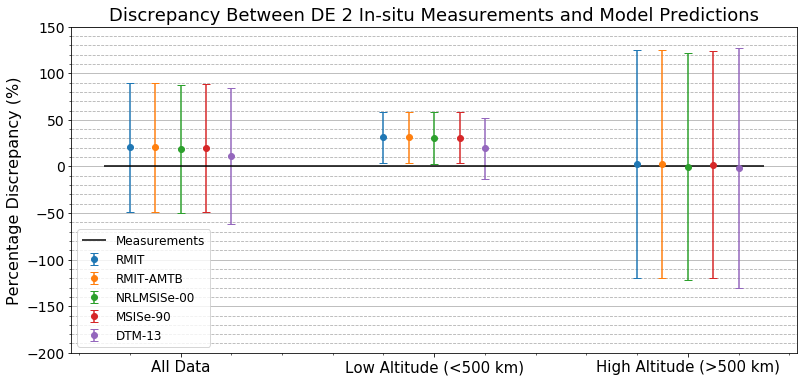

In [20]:
cond_list = [cond_a, lo_alt, hi_alt]
var = log_var
df_list = [df_RMIT_clean,df_RMIT2_clean, df_N00_clean, df_M90_clean, df_D13_clean]
xlab_list = ['All Data','Low Altitude (<500 km)', 'High Altitude (>500 km)']
model_list = ['RMIT', 'RMIT-AMTB', 'NRLMSISe-00', 'MSISe-90', 'DTM-13']
title_str = 'Discrepancy Between DE 2 In-situ Measurements and Model Predictions'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

<br>
<br>

- **What is the distribution of the longitude and latitudes, is there a bias towards certain coordinates?**
    
We can produce a histogram of the longitudes and latitudes to gain an understandhing of the distribution:    

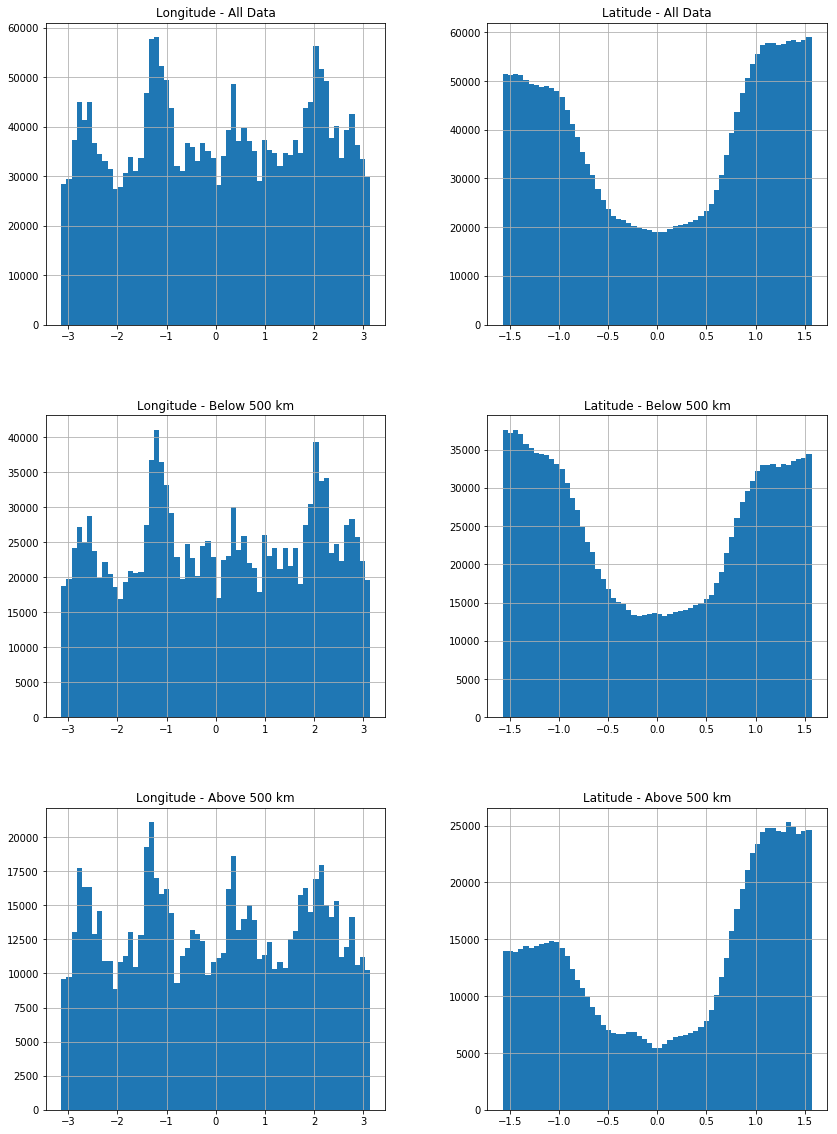

In [21]:
fig1, ax1 = plt.subplots(3,2, figsize=(14,20)) # ,sharex='col', sharey='row')
df_RMIT_clean.hist(
    column='Longitude',
    bins=60, 
    ax=ax1[0,0]
    #density=True
    )

df_RMIT_clean.hist(
    column='Latitude',
    bins=60, 
    ax=ax1[0,1]
    #density=True,
    )

df_RMIT_clean[lo_alt].hist(
    column='Longitude',
    bins=60, 
    ax=ax1[1,0]
    #density=True
    )

df_RMIT_clean[lo_alt].hist(
    column='Latitude',
    bins=60, 
    ax=ax1[1,1]
    #density=True,
    )
df_RMIT_clean[hi_alt].hist(
    column='Longitude',
    bins=60, 
    ax=ax1[2,0]
    #density=True
    )

df_RMIT_clean[hi_alt].hist(
    column='Latitude',
    bins=60, 
    ax=ax1[2,1]
    #density=True,
    )
ax1[0,0].set_title('Longitude - All Data')
ax1[0,1].set_title('Latitude - All Data')
ax1[1,0].set_title('Longitude - Below 500 km')
ax1[1,1].set_title('Latitude - Below 500 km')
ax1[2,0].set_title('Longitude - Above 500 km')
ax1[2,1].set_title('Latitude - Above 500 km')
plt.show(fig1)
plt.close(fig1)

The Longitude coordinates are relatively evenly distributed, with a couple peaks at about -1.2 and 2.1 radians, with smaller
peaks at around 0.5 and -2.8. 
In the case of the Latitude coordinates there is a clear over representation of high-latitude data in both the north and south
polar regions.

These distributions are similar for below and above 500 km altitude however there is a much lower collection of data 
for southern polar coordinates. 

What we can do is create evenly distributions from the entire dataset. Creating a sample size 98% of the smallest bin in the histogram, we randomly pick rows without replacement for each of the bins. This smaller but evenly distributed dataset will now act as the dataframe from which we can find mean and standard deviation. We have done this for the longitude and latitude histograms above.
<br>
<br>    


In [22]:
# Have one function to randomly sample the dataframe to obtain a data set consistent across the variable being sampled
# Another function will calculate the mean and standard deviation (e.g. the ones that already exist)

def even_dist_sampling(df, cond, samp_var, no_bins = 60):
    # Create conditions:
    df1 = df[cond]
    df_run = df1[samp_var]

    hist, bin_edges = np.histogram(df_run,bins=no_bins)

    # Calculate the weights for each bin
    hist_prob = hist/sum(hist)

    # Use a sampling number based on with the lowest number of samples:
    no_samps = int(round(0.98*hist.min()))

    # bin idexes:
    bin_idxs = []

    for idx,edge in enumerate(bin_edges[:-1]):
        edge2 = bin_edges[idx+1]
        cond = (df_run >= edge) & (df_run < edge2)
        s_idxs = df_run[cond].index
        chosen = np.random.choice(s_idxs, no_samps, replace=False)
        bin_idxs.extend(chosen)
        
    return bin_idxs


In [23]:
# Define the indexes to use based on previous function
even_idx_long = even_dist_sampling(df_RMIT_clean,cond_a,'Longitude')
even_idx_lat = even_dist_sampling(df_RMIT_clean,cond_a,'Latitude')

even_idx_lo_long = even_dist_sampling(df_RMIT_clean,lo_alt,'Longitude')
even_idx_lo_lat = even_dist_sampling(df_RMIT_clean,lo_alt,'Latitude')
even_idx_hi_long = even_dist_sampling(df_RMIT_clean,hi_alt,'Longitude')
even_idx_hi_lat = even_dist_sampling(df_RMIT_clean,hi_alt,'Latitude')

Let's re-plot the histograms from before to see the effect of sampling from the bins and ensuring the same number of data points are found in each bin:

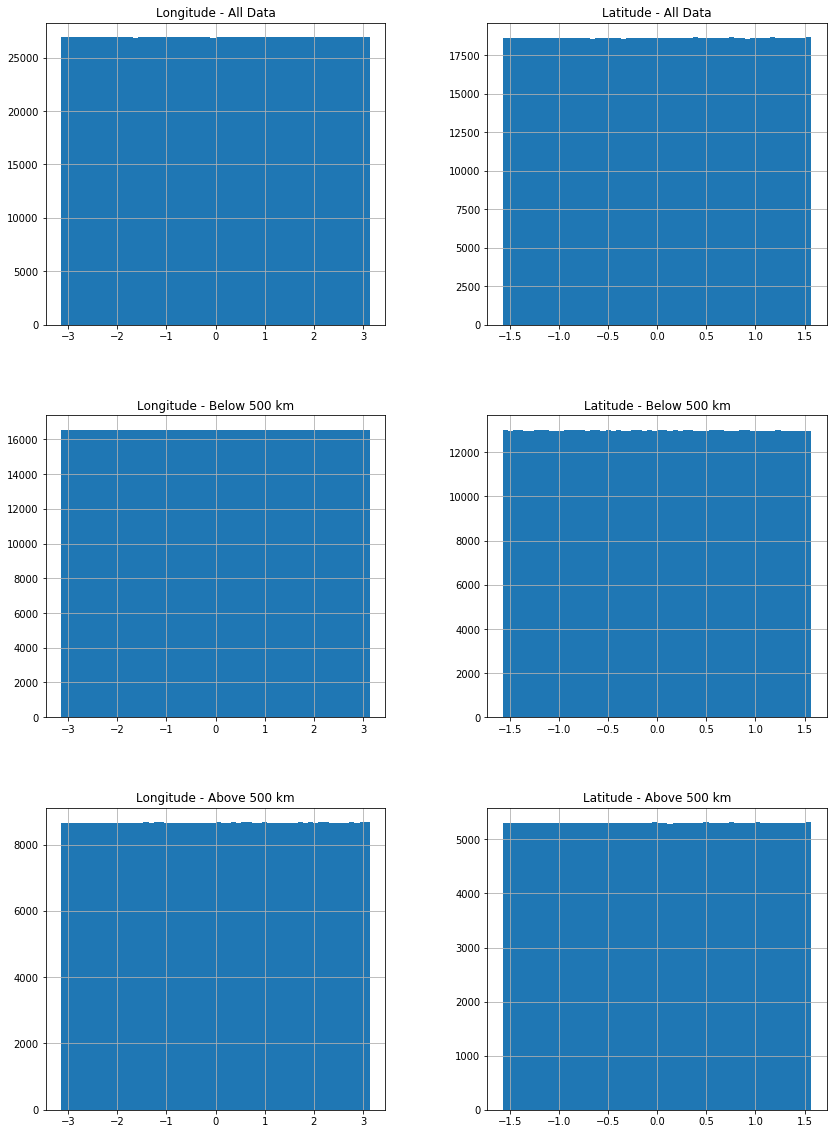

In [24]:
fig1, ax1 = plt.subplots(3,2, figsize=(14,20)) # ,sharex='col', sharey='row')


df_RMIT_clean.loc[even_idx_long].hist(
    column='Longitude',
    bins=60, 
    ax=ax1[0,0]
    #density=True
    )

df_RMIT_clean.loc[even_idx_lat].hist(
    column='Latitude',
    bins=60, 
    ax=ax1[0,1]
    #density=True,
    )

df_RMIT_clean.loc[even_idx_lo_long].hist(
    column='Longitude',
    bins=60, 
    ax=ax1[1,0]
    #density=True
    )

df_RMIT_clean.loc[even_idx_lo_lat].hist(
    column='Latitude',
    bins=60, 
    ax=ax1[1,1]
    #density=True,
    )

df_RMIT_clean.loc[even_idx_hi_long].hist(
    column='Longitude',
    bins=60, 
    ax=ax1[2,0]
    #density=True
    )

df_RMIT_clean.loc[even_idx_hi_lat].hist(
    column='Latitude',
    bins=60, 
    ax=ax1[2,1]
    #density=True,
    )

ax1[0,0].set_title('Longitude - All Data')
ax1[0,1].set_title('Latitude - All Data')
ax1[1,0].set_title('Longitude - Below 500 km')
ax1[1,1].set_title('Latitude - Below 500 km')
ax1[2,0].set_title('Longitude - Above 500 km')
ax1[2,1].set_title('Latitude - Above 500 km')
plt.show(fig1)
plt.close(fig1)

We will use these even distributions to calculate the model means / standard deviations.

In [25]:
def create_3cond_table(df1,df2,df3,df4,df5,modlab1,modlab2,modlab3,modlab4,modlab5,cond1,cond2,cond3,var,condlab1,condlab2,condlab3):
    output = f"""
<table>
<tr>
<td align="center">
{create_mean_std_table5(df1,df2, df3, df4, df5, modlab1, modlab2, modlab3, modlab4, modlab5, cond1, var, condlab1, pts_fl=False)}
{create_mean_std_table5(df1,df2, df3, df4, df5, modlab1, modlab2, modlab3, modlab4, modlab5, cond2, var, condlab2, pts_fl=False)}
{create_mean_std_table5(df1,df2, df3, df4, df5, modlab1, modlab2, modlab3, modlab4, modlab5, cond3, var, condlab3, pts_fl=False)}
</td>
</tr> 
</table>
"""
    return output

- **What are the mean and std. for high-, mid- and low-latitudes?**

#### All Data:

In [26]:
cond_high_lat = (
            (df_RMIT_clean['Latitude'].loc[even_idx_lat] > 1.0) | 
            (df_RMIT_clean['Latitude'].loc[even_idx_lat] < -1.0)
            )

cond_mid_lat = (
            (
            (df_RMIT_clean['Latitude'].loc[even_idx_lat] > 0.5) &
            (df_RMIT_clean['Latitude'].loc[even_idx_lat] < 1.0)
            ) 
            | 
            ((df_RMIT_clean['Latitude'].loc[even_idx_lat] > -1.0) & 
            (df_RMIT_clean['Latitude'].loc[even_idx_lat] < -0.5))
            )
            
cond_low_lat = (
            (df_RMIT_clean['Latitude'].loc[even_idx_lat] < 0.5) &
            (df_RMIT_clean['Latitude'].loc[even_idx_lat] > -0.5)
            )

In [27]:
display(Markdown(create_3cond_table(df1 = df_RMIT_clean.loc[even_idx_lat],
                   df2 = df_RMIT2_clean.loc[even_idx_lat],
                   df3 = df_N00_clean.loc[even_idx_lat],
                   df4 = df_M90_clean.loc[even_idx_lat],
                   df5 = df_D13_clean.loc[even_idx_lat],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_high_lat,
                   cond2 = cond_mid_lat,
                   cond3 = cond_low_lat,
                   var = log_var,
                   condlab1 = 'High-Latitude',
                   condlab2 = 'Mid-Latitude',
                   condlab3 = 'Low-Latitude')))


<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>High-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>17.203 %</td>
      <td>17.165 %</td>
      <td>16.777 %</td>
      <td>16.745 %</td>
      <td>9.511 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>72.21 %</td>
      <td>72.23 %</td>
      <td>72.28 %</td>
      <td>72.36 %</td>
      <td>76.60 %</td>
    </tr>
  </tbody>
</table>
        

<table>
  <thead>
    <tr>
      <th>Mid-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>21.654 %</td>
      <td>21.605 %</td>
      <td>18.614 %</td>
      <td>21.013 %</td>
      <td>12.162 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>69.07 %</td>
      <td>69.08 %</td>
      <td>69.54 %</td>
      <td>69.15 %</td>
      <td>73.52 %</td>
    </tr>
  </tbody>
</table>
        

<table>
  <thead>
    <tr>
      <th>Low-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>28.715 %</td>
      <td>28.563 %</td>
      <td>25.202 %</td>
      <td>27.563 %</td>
      <td>15.296 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>52.23 %</td>
      <td>52.22 %</td>
      <td>53.07 %</td>
      <td>52.53 %</td>
      <td>53.79 %</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


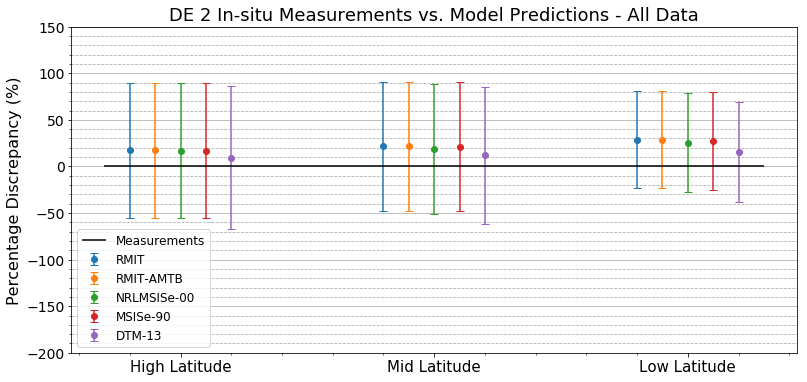

In [28]:
cond_list = [cond_high_lat, cond_mid_lat, cond_low_lat]
var = log_var
df_list = [df_RMIT_clean.loc[even_idx_lat], 
           df_RMIT2_clean.loc[even_idx_lat], 
           df_N00_clean.loc[even_idx_lat], 
           df_M90_clean.loc[even_idx_lat], 
           df_D13_clean.loc[even_idx_lat]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - All Data'
xlab_list = ['High Latitude','Mid Latitude', 'Low Latitude']

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

#### Below 500 km:    

In [29]:
# Conditional masks - low altitude
cond_high_lat_lo_alt = (
            (df_RMIT_clean['Latitude'].loc[even_idx_lo_lat] > 1.0) | 
            (df_RMIT_clean['Latitude'].loc[even_idx_lo_lat] < -1.0)
            )

cond_mid_lat_lo_alt = (
            (
            (df_RMIT_clean['Latitude'].loc[even_idx_lo_lat] > 0.5) &
            (df_RMIT_clean['Latitude'].loc[even_idx_lo_lat] < 1.0)
            ) 
            | 
            ((df_RMIT_clean['Latitude'].loc[even_idx_lo_lat] > -1.0) & 
            (df_RMIT_clean['Latitude'].loc[even_idx_lo_lat] < -0.5))
            )
            
cond_low_lat_lo_alt = (
            (df_RMIT_clean['Latitude'].loc[even_idx_lo_lat] < 0.5) &
            (df_RMIT_clean['Latitude'].loc[even_idx_lo_lat] > -0.5)
            )

# Conditional masks - high altitude
cond_high_lat_hi_alt = (
            (df_RMIT_clean['Latitude'].loc[even_idx_hi_lat] > 1.0) | 
            (df_RMIT_clean['Latitude'].loc[even_idx_hi_lat] < -1.0)
            )

cond_mid_lat_hi_alt = (
            (
            (df_RMIT_clean['Latitude'].loc[even_idx_hi_lat] > 0.5) &
            (df_RMIT_clean['Latitude'].loc[even_idx_hi_lat] < 1.0)
            ) 
            | 
            ((df_RMIT_clean['Latitude'].loc[even_idx_hi_lat] > -1.0) & 
            (df_RMIT_clean['Latitude'].loc[even_idx_hi_lat] < -0.5))
            )
            
cond_low_lat_hi_alt = (
            (df_RMIT_clean['Latitude'].loc[even_idx_hi_lat] < 0.5) &
            (df_RMIT_clean['Latitude'].loc[even_idx_hi_lat] > -0.5)
            )

In [30]:
display(Markdown(create_3cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_lat],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_lat],
                   df3 = df_N00_clean.loc[even_idx_lo_lat],
                   df4 = df_M90_clean.loc[even_idx_lo_lat],
                   df5 = df_D13_clean.loc[even_idx_lo_lat],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_high_lat_lo_alt,
                   cond2 = cond_mid_lat_lo_alt,
                   cond3 = cond_low_lat_lo_alt,
                   var = log_var,
                   condlab1 = 'High-Latitude',
                   condlab2 = 'Mid-Latitude',
                   condlab3 = 'Low-Latitude')))


<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>High-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>31.593 %</td>
      <td>31.571 %</td>
      <td>31.640 %</td>
      <td>31.411 %</td>
      <td>21.850 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>31.53 %</td>
      <td>31.53 %</td>
      <td>31.22 %</td>
      <td>31.55 %</td>
      <td>37.46 %</td>
    </tr>
  </tbody>
</table>
        

<table>
  <thead>
    <tr>
      <th>Mid-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>29.235 %</td>
      <td>29.203 %</td>
      <td>28.041 %</td>
      <td>28.973 %</td>
      <td>17.068 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>25.89 %</td>
      <td>25.89 %</td>
      <td>26.02 %</td>
      <td>25.88 %</td>
      <td>31.34 %</td>
    </tr>
  </tbody>
</table>
        

<table>
  <thead>
    <tr>
      <th>Low-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>34.104 %</td>
      <td>34.014 %</td>
      <td>30.912 %</td>
      <td>33.605 %</td>
      <td>16.305 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>17.42 %</td>
      <td>17.42 %</td>
      <td>17.50 %</td>
      <td>17.42 %</td>
      <td>22.47 %</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


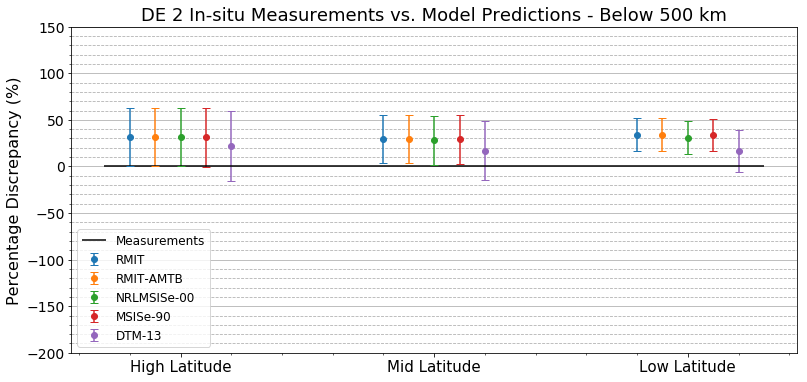

In [31]:
cond_list = [cond_high_lat_lo_alt, cond_mid_lat_lo_alt, cond_low_lat_lo_alt]
var = log_var
df_list = [df_RMIT_clean.loc[even_idx_lo_lat], 
           df_RMIT2_clean.loc[even_idx_lo_lat], 
           df_N00_clean.loc[even_idx_lo_lat], 
           df_M90_clean.loc[even_idx_lo_lat], 
           df_D13_clean.loc[even_idx_lo_lat]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - Below 500 km'
xlab_list = ['High Latitude','Mid Latitude', 'Low Latitude']

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

#### Above 500 km:    

In [32]:
display(Markdown(create_3cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_lat],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_lat],
                   df3 = df_N00_clean.loc[even_idx_hi_lat],
                   df4 = df_M90_clean.loc[even_idx_hi_lat],
                   df5 = df_D13_clean.loc[even_idx_hi_lat],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_high_lat_hi_alt,
                   cond2 = cond_mid_lat_hi_alt,
                   cond3 = cond_low_lat_hi_alt,
                   var = log_var,
                   condlab1 = 'High-Latitude',
                   condlab2 = 'Mid-Latitude',
                   condlab3 = 'Low-Latitude')))


<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>High-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>-5.067 %</td>
      <td>-5.127 %</td>
      <td>-6.136 %</td>
      <td>-5.879 %</td>
      <td>-9.315 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>121.70 %</td>
      <td>121.71 %</td>
      <td>121.39 %</td>
      <td>121.65 %</td>
      <td>127.34 %</td>
    </tr>
  </tbody>
</table>
        

<table>
  <thead>
    <tr>
      <th>Mid-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>7.259 %</td>
      <td>7.189 %</td>
      <td>1.419 %</td>
      <td>6.044 %</td>
      <td>2.842 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>128.47 %</td>
      <td>128.47 %</td>
      <td>128.04 %</td>
      <td>128.36 %</td>
      <td>136.40 %</td>
    </tr>
  </tbody>
</table>
        

<table>
  <thead>
    <tr>
      <th>Low-Latitude</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>17.704 %</td>
      <td>17.434 %</td>
      <td>13.600 %</td>
      <td>15.317 %</td>
      <td>13.238 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>101.88 %</td>
      <td>101.82 %</td>
      <td>103.65 %</td>
      <td>102.18 %</td>
      <td>102.73 %</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


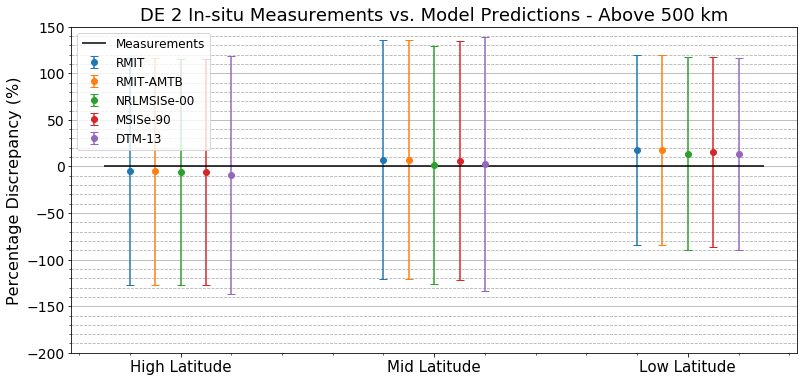

In [33]:
cond_list = [cond_high_lat_hi_alt, cond_mid_lat_hi_alt, cond_low_lat_hi_alt]
var = log_var
df_list = [df_RMIT_clean.loc[even_idx_hi_lat], 
           df_RMIT2_clean.loc[even_idx_hi_lat], 
           df_N00_clean.loc[even_idx_hi_lat], 
           df_M90_clean.loc[even_idx_hi_lat], 
           df_D13_clean.loc[even_idx_hi_lat]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - Above 500 km'
xlab_list = ['High Latitude','Mid Latitude', 'Low Latitude']

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

High latitude were defined as above 1 or below -1 radians.
Mid-latitudes were defined as below 1 and -0.5, and above 0.5 and -1.
Low latitudes were defind as above -0.5 and below 0.5.

Comparing high-, mid- and low-latitude data, the low-latitude model predictions are furthest from their corresponding 
measurements. This is true for all data together as well as the high and low altitude cases. However in all cases the
low-latitude case has the lowest variability in the given dataset.

The low altitude data, which is apparently the most reliable, is actually on average further away from the model predictions
compared to the high altitude data. However, the standard deviations for the lower altitudes are much smaller than the high 
altitude case, but still very close to the size of the mean as well. Therefore, although the mean suggests the predictions are 
generally overestimating the measurements for low altitudes the large standard deviation suggests that the models are only
slightly biased, as the 0.0 % mark is well within 1.5 sigma. Therefore the accuracy of the two models is similar, as well as
the precision. 

The precision is generally bad, especially in the high altitude case, with a standard deviation of over 100 % for all latitudes.
For the high altitude and high latitude case, the models both marginally underestimate the measured density but these results 
are also closest to 0.0 % out of all those investigated above (the mid-latitude N-00 results are slightly better albeit with 
a higher standard deviation).

As in the previous table looking at data in the high and low altitude cases, the standard deviation is marginally lower for the
RMIT model in a number of cases (low and high latitudes for altitudes > 500 km and low and mid latitudes for altitudes < 500 km). 
The RMIT model is also marginally closer to the measurement data for high latitudes in the below 500 km and above 500 km
datasets individually.

- **What are the mean and std. for different times of day? (morning, mid-day, afternoon, night, etc)**

Initially the only variable available was Universl Time (UT). To convert UT to solar time I used the following formula:
```
Solar_Local_Time = Decimal_Hr + Longitude/(pi/12)
```with adjustments made for hours output as above 2400 (-24) and under 0000 (+24). 

The distribution of this new variable is:


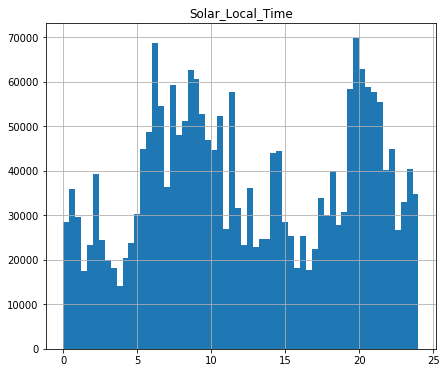

In [34]:
fig2, ax2 = plt.subplots(1,1, figsize=(7,6))
df_RMIT_clean.hist(
    column='Solar_Local_Time',
    bins=60,
    ax=ax2
    )
plt.show(fig2)
plt.close(fig2)

The different times of day I've defined as:

- Sunrise 0530 - 0730, 
- Morning 0730 - 1130, 
- Midday 1130 - 1230, 
- Afternoon 1230 - 1700, 
- Sunset 1700-1930, 
- Night as 1930 - 2330, 
- Midnight 2330 - 0030, 
- After midnight 0030 - 0530. 

Again we can evenly distribute the data and calculate means / standard deviation from the evenly distributed samples. The histogram for this is again shown below:

In [35]:
slt_var = 'Solar_Local_Time'

even_idx_sol = even_dist_sampling(df_RMIT_clean,cond_a,'Solar_Local_Time')
even_idx_lo_sol = even_dist_sampling(df_RMIT_clean,lo_alt,'Solar_Local_Time')
even_idx_hi_sol = even_dist_sampling(df_RMIT_clean,hi_alt,'Solar_Local_Time')

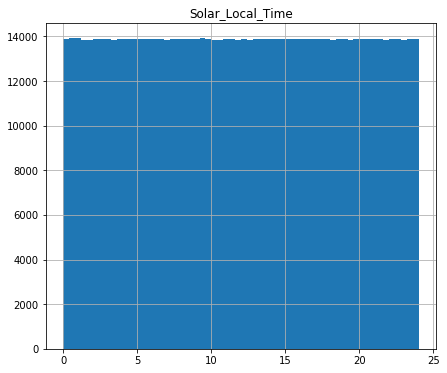

In [36]:
fig2, ax2 = plt.subplots(1,1, figsize=(7,6))
df_RMIT_clean.loc[even_idx_sol].hist(
    column='Solar_Local_Time',
    bins=60,
    ax=ax2
    )
plt.show(fig2)
plt.close(fig2)

The results below are divided up into 8 times of day, as defined previously and separated into above and below 
500 km to view the regions were reliable data is present. 

In [37]:
# Creating masks

# Diff solar times - all data
cond_sunrise = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] > 5.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] < 7.5)
            )

cond_morning = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] > 7.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] < 11.5)
            )

cond_midday = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] > 11.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] < 12.5)
            )

cond_aftnoon = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] > 12.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] < 17.0)
            )

cond_sunset = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] > 17.0) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] < 19.5)
            )

cond_night = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] > 19.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] < 23.5)
            )

cond_midnight = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] > 23.5) | 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] < 0.5)
            )

cond_aftmidnite = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] > 0.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_sol] < 5.5)
            )


# Diff solar times - < 500 km
cond_sunrise_lo_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] > 5.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] < 7.5)
            )

cond_morning_lo_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] > 7.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] < 11.5)
            )

cond_midday_lo_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] > 11.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] < 12.5)
            )

cond_aftnoon_lo_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] > 12.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] < 17.0)
            )

cond_sunset_lo_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] > 17.0) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] < 19.5)
            )

cond_night_lo_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] > 19.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] < 23.5)
            )

cond_midnight_lo_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] > 23.5) | 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] < 0.5)
            )

cond_aftmidnite_lo_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] > 0.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_lo_sol] < 5.5)
            )


# Diff solar times - > 500 km
cond_sunrise_hi_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] > 5.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] < 7.5)
            )

cond_morning_hi_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] > 7.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] < 11.5)
            )

cond_midday_hi_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] > 11.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] < 12.5)
            )

cond_aftnoon_hi_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] > 12.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] < 17.0)
            )

cond_sunset_hi_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] > 17.0) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] < 19.5)
            )

cond_night_hi_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] > 19.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] < 23.5)
            )

cond_midnight_hi_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] > 23.5) | 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] < 0.5)
            )

cond_aftmidnite_hi_alt = (
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] > 0.5) & 
            (df_RMIT_clean['Solar_Local_Time'].loc[even_idx_hi_sol] < 5.5)
            )

In [38]:
def create_2cond_table(df1,df2,df3,df4,df5,modlab1,modlab2,modlab3,modlab4,modlab5,cond1,cond2,var,condlab1,condlab2):
    output = f"""
<table>
<tr>
<td align="center">
{create_mean_std_table5(df1,df2, df3, df4, df5, modlab1, modlab2, modlab3, modlab4, modlab5, cond1, var, condlab1, pts_fl=True)}
</td><td align="center">
{create_mean_std_table5(df1,df2, df3, df4, df5, modlab1, modlab2, modlab3, modlab4, modlab5, cond2, var, condlab2, pts_fl=True)}
</td>
</tr> 
</table>
"""
    return output

#### All Data:

In [39]:
display(Markdown(create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_sol],
                   df3 = df_N00_clean.loc[even_idx_sol],
                   df4 = df_M90_clean.loc[even_idx_sol],
                   df5 = df_D13_clean.loc[even_idx_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_sunrise,
                   cond2 = cond_morning,
                   var = log_var,
                   condlab1 = 'Sunrise',
                   condlab2 = 'Morning') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_sol],
                   df3 = df_N00_clean.loc[even_idx_sol],
                   df4 = df_M90_clean.loc[even_idx_sol],
                   df5 = df_D13_clean.loc[even_idx_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_midday,
                   cond2 = cond_aftnoon,
                   var = log_var,
                   condlab1 = 'Midday',
                   condlab2 = 'Afternoon')+ 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_sol],
                   df3 = df_N00_clean.loc[even_idx_sol],
                   df4 = df_M90_clean.loc[even_idx_sol],
                   df5 = df_D13_clean.loc[even_idx_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_sunset,
                   cond2 = cond_night,
                   var = log_var,
                   condlab1 = 'Sunset',
                   condlab2 = 'Night')+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_sol],
                   df3 = df_N00_clean.loc[even_idx_sol],
                   df4 = df_M90_clean.loc[even_idx_sol],
                   df5 = df_D13_clean.loc[even_idx_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_midnight,
                   cond2 = cond_aftmidnite,
                   var = log_var,
                   condlab1 = 'Midnight',
                   condlab2 = 'After Midnight')))


<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Sunrise</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>27.386 %</td>
      <td>27.323 %</td>
      <td>23.318 %</td>
      <td>26.954 %</td>
      <td>9.186 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>43.91 %</td>
      <td>43.90 %</td>
      <td>45.63 %</td>
      <td>43.91 %</td>
      <td>44.73 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>68526</td>
      <td>68526</td>
      <td>68526</td>
      <td>68526</td>
      <td>68526</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Morning</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>19.884 %</td>
      <td>19.834 %</td>
      <td>15.880 %</td>
      <td>19.207 %</td>
      <td>16.198 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>81.39 %</td>
      <td>81.39 %</td>
      <td>82.09 %</td>
      <td>81.37 %</td>
      <td>86.95 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>139148</td>
      <td>139148</td>
      <td>139148</td>
      <td>139148</td>
      <td>139148</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Midday</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>29.118 %</td>
      <td>29.086 %</td>
      <td>22.416 %</td>
      <td>28.398 %</td>
      <td>34.377 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>38.08 %</td>
      <td>38.10 %</td>
      <td>40.58 %</td>
      <td>38.25 %</td>
      <td>38.35 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>34353</td>
      <td>34353</td>
      <td>34353</td>
      <td>34353</td>
      <td>34353</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Afternoon</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>26.484 %</td>
      <td>26.455 %</td>
      <td>25.947 %</td>
      <td>25.993 %</td>
      <td>14.186 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>46.26 %</td>
      <td>46.26 %</td>
      <td>45.50 %</td>
      <td>46.33 %</td>
      <td>46.89 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>154539</td>
      <td>154539</td>
      <td>154539</td>
      <td>154539</td>
      <td>154539</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Sunset</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>38.212 %</td>
      <td>38.159 %</td>
      <td>36.795 %</td>
      <td>37.642 %</td>
      <td>26.781 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>48.94 %</td>
      <td>48.93 %</td>
      <td>49.93 %</td>
      <td>48.87 %</td>
      <td>53.36 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>87046</td>
      <td>87046</td>
      <td>87046</td>
      <td>87046</td>
      <td>87046</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Night</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>13.905 %</td>
      <td>13.819 %</td>
      <td>13.775 %</td>
      <td>13.061 %</td>
      <td>10.326 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>75.29 %</td>
      <td>75.31 %</td>
      <td>74.31 %</td>
      <td>75.37 %</td>
      <td>81.54 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>138980</td>
      <td>138980</td>
      <td>138980</td>
      <td>138980</td>
      <td>138980</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Midnight</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>25.106 %</td>
      <td>25.073 %</td>
      <td>22.431 %</td>
      <td>24.599 %</td>
      <td>24.071 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>69.60 %</td>
      <td>69.63 %</td>
      <td>72.97 %</td>
      <td>70.52 %</td>
      <td>66.38 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>35449</td>
      <td>35449</td>
      <td>35449</td>
      <td>35449</td>
      <td>35449</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>After Midnight</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>6.305 %</td>
      <td>6.249 %</td>
      <td>7.091 %</td>
      <td>5.763 %</td>
      <td>-9.285 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>108.20 %</td>
      <td>108.21 %</td>
      <td>109.08 %</td>
      <td>108.58 %</td>
      <td>113.47 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>174099</td>
      <td>174099</td>
      <td>174099</td>
      <td>174099</td>
      <td>174099</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


The tables above for the 'All Data' case show the number of points for a given solar time 'time of day' group as well as the mean and standard deviation. The mean discrepancy between model and measurement is between -9 % and 38 %, depending on
the time of day and the model. The standard deviations range between 38 % and 113 %. The midday to sunset time period shows the small standard deviation amongst all the models, with sunrise also generally having smaller variation. After midnight has the largest deviation for all models.

Apart from the midday, midnight and after-midnight periods the DTM-2013 model does noticeably better than the other models, as seen in the figure below, with sunrise, afternoon and sunset clearly closer to the zero line. However, midday is a problematic time period for the DTM-2013 model, doing worse than all the others, and NRLMSIS-00 doing noticeably better than the others.

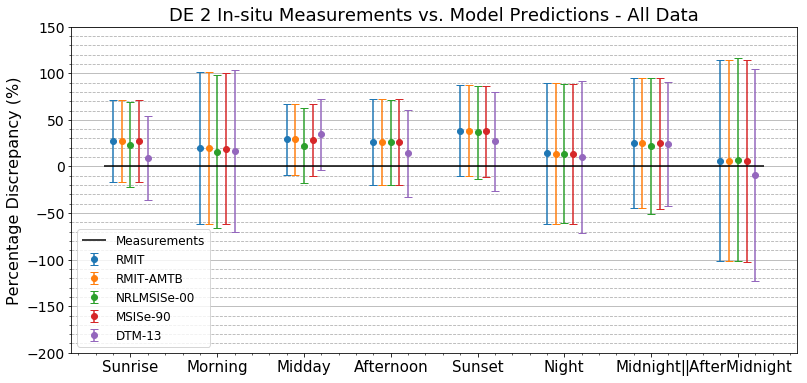

In [40]:
cond_list = [cond_sunrise, cond_morning, cond_midday, cond_aftnoon, cond_sunset, cond_night, cond_midnight, cond_aftmidnite]
var = log_var

xlab_list = ['Sunrise','Morning', 'Midday','Afternoon','Sunset','Night','Midnight|','|AfterMidnight']
df_list = [df_RMIT_clean.loc[even_idx_sol], 
           df_RMIT2_clean.loc[even_idx_sol], 
           df_N00_clean.loc[even_idx_sol], 
           df_M90_clean.loc[even_idx_sol], 
           df_D13_clean.loc[even_idx_sol]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - All Data'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

#### Below 500 km:

In [41]:
display(Markdown(create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_sol],
                   df3 = df_N00_clean.loc[even_idx_lo_sol],
                   df4 = df_M90_clean.loc[even_idx_lo_sol],
                   df5 = df_D13_clean.loc[even_idx_lo_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_sunrise_lo_alt,
                   cond2 = cond_morning_lo_alt,
                   var = log_var,
                   condlab1 = 'Sunrise',
                   condlab2 = 'Morning') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_sol],
                   df3 = df_N00_clean.loc[even_idx_lo_sol],
                   df4 = df_M90_clean.loc[even_idx_lo_sol],
                   df5 = df_D13_clean.loc[even_idx_lo_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_midday_lo_alt,
                   cond2 = cond_aftnoon_lo_alt,
                   var = log_var,
                   condlab1 = 'Midday',
                   condlab2 = 'Afternoon')+ 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_sol],
                   df3 = df_N00_clean.loc[even_idx_lo_sol],
                   df4 = df_M90_clean.loc[even_idx_lo_sol],
                   df5 = df_D13_clean.loc[even_idx_lo_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_sunset_lo_alt,
                   cond2 = cond_night_lo_alt,
                   var = log_var,
                   condlab1 = 'Sunset',
                   condlab2 = 'Night')+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_sol],
                   df3 = df_N00_clean.loc[even_idx_lo_sol],
                   df4 = df_M90_clean.loc[even_idx_lo_sol],
                   df5 = df_D13_clean.loc[even_idx_lo_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_midnight_lo_alt,
                   cond2 = cond_aftmidnite_lo_alt,
                   var = log_var,
                   condlab1 = 'Midnight',
                   condlab2 = 'After Midnight')))


<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Sunrise</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>33.536 %</td>
      <td>33.470 %</td>
      <td>31.080 %</td>
      <td>33.203 %</td>
      <td>15.129 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>17.09 %</td>
      <td>17.08 %</td>
      <td>16.46 %</td>
      <td>17.07 %</td>
      <td>22.44 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>37456</td>
      <td>37456</td>
      <td>37456</td>
      <td>37456</td>
      <td>37456</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Morning</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>27.535 %</td>
      <td>27.503 %</td>
      <td>25.505 %</td>
      <td>27.265 %</td>
      <td>19.077 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>36.75 %</td>
      <td>36.76 %</td>
      <td>36.93 %</td>
      <td>36.77 %</td>
      <td>44.95 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>74677</td>
      <td>74677</td>
      <td>74677</td>
      <td>74677</td>
      <td>74677</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Midday</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>33.195 %</td>
      <td>33.177 %</td>
      <td>28.271 %</td>
      <td>32.962 %</td>
      <td>36.360 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>17.89 %</td>
      <td>17.90 %</td>
      <td>17.99 %</td>
      <td>17.90 %</td>
      <td>23.52 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>17650</td>
      <td>17650</td>
      <td>17650</td>
      <td>17650</td>
      <td>17650</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Afternoon</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>30.674 %</td>
      <td>30.643 %</td>
      <td>29.753 %</td>
      <td>30.392 %</td>
      <td>18.203 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>20.99 %</td>
      <td>21.00 %</td>
      <td>20.58 %</td>
      <td>21.00 %</td>
      <td>24.16 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>84141</td>
      <td>84141</td>
      <td>84141</td>
      <td>84141</td>
      <td>84141</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Sunset</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>39.228 %</td>
      <td>39.207 %</td>
      <td>37.387 %</td>
      <td>39.043 %</td>
      <td>28.361 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>20.29 %</td>
      <td>20.29 %</td>
      <td>20.56 %</td>
      <td>20.26 %</td>
      <td>24.52 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>46689</td>
      <td>46689</td>
      <td>46689</td>
      <td>46689</td>
      <td>46689</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Night</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>27.912 %</td>
      <td>27.860 %</td>
      <td>29.258 %</td>
      <td>27.612 %</td>
      <td>22.339 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>45.43 %</td>
      <td>45.44 %</td>
      <td>45.35 %</td>
      <td>45.47 %</td>
      <td>51.44 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>74969</td>
      <td>74969</td>
      <td>74969</td>
      <td>74969</td>
      <td>74969</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Midnight</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>43.158 %</td>
      <td>43.138 %</td>
      <td>41.683 %</td>
      <td>42.945 %</td>
      <td>39.116 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>23.91 %</td>
      <td>23.92 %</td>
      <td>24.51 %</td>
      <td>23.89 %</td>
      <td>27.27 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>19424</td>
      <td>19424</td>
      <td>19424</td>
      <td>19424</td>
      <td>19424</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>After Midnight</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>31.759 %</td>
      <td>31.732 %</td>
      <td>32.601 %</td>
      <td>31.563 %</td>
      <td>11.587 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>25.96 %</td>
      <td>25.97 %</td>
      <td>25.67 %</td>
      <td>26.00 %</td>
      <td>31.97 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>93554</td>
      <td>93554</td>
      <td>93554</td>
      <td>93554</td>
      <td>93554</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


The tables above for the 'Below 500 km' case have a much lower standard deviation than those for all the data. The mean discrepancy between model and measurement is between 11 % and 43 %. Again, the midday to sunset time period shows smaller standard deviation amongst all the models although sunrise has the smallest variation for all models. After midnight is no longer the period with most variability, that title moving to the 'night' period.

The DTM-2013 model is once again the stand-out performer on the mean discrepancy front, however at midday it is still the worst performing. The figure below shows this quite clearly, and also the much smaller variability across all models. does noticeably better than the other models, as seen in the figure below, with sunrise, afternoon and sunset clearly closer to the zero line. However, midday is a problematic time period for the DTM-2013 model, doing worse than all the others, and NRLMSIS-00 doing noticeably better than the others.

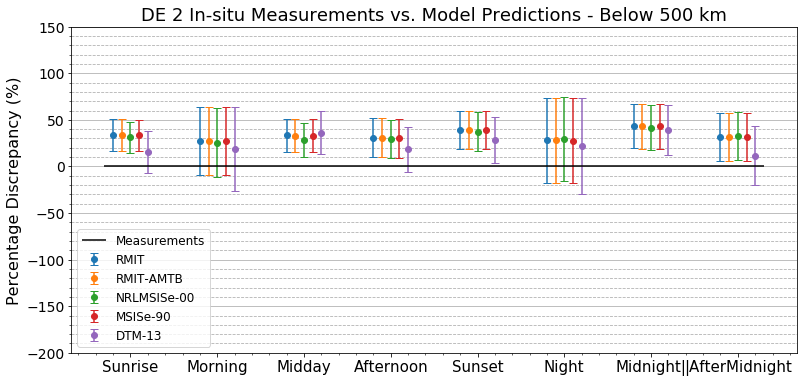

In [42]:
cond_list = [cond_sunrise_lo_alt, 
             cond_morning_lo_alt, 
             cond_midday_lo_alt, 
             cond_aftnoon_lo_alt, 
             cond_sunset_lo_alt, 
             cond_night_lo_alt, 
             cond_midnight_lo_alt, 
             cond_aftmidnite_lo_alt]


xlab_list = ['Sunrise','Morning', 'Midday','Afternoon','Sunset','Night','Midnight|','|AfterMidnight']
df_list = [df_RMIT_clean.loc[even_idx_lo_sol], 
           df_RMIT2_clean.loc[even_idx_lo_sol], 
           df_N00_clean.loc[even_idx_lo_sol], 
           df_M90_clean.loc[even_idx_lo_sol], 
           df_D13_clean.loc[even_idx_lo_sol]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - Below 500 km'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

#### Above 500 km

In [43]:
display(Markdown(create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_sol],
                   df3 = df_N00_clean.loc[even_idx_hi_sol],
                   df4 = df_M90_clean.loc[even_idx_hi_sol],
                   df5 = df_D13_clean.loc[even_idx_hi_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_sunrise_hi_alt,
                   cond2 = cond_morning_hi_alt,
                   var = log_var,
                   condlab1 = 'Sunrise',
                   condlab2 = 'Morning') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_sol],
                   df3 = df_N00_clean.loc[even_idx_hi_sol],
                   df4 = df_M90_clean.loc[even_idx_hi_sol],
                   df5 = df_D13_clean.loc[even_idx_hi_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_midday_hi_alt,
                   cond2 = cond_aftnoon_hi_alt,
                   var = log_var,
                   condlab1 = 'Midday',
                   condlab2 = 'Afternoon')+ 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_sol],
                   df3 = df_N00_clean.loc[even_idx_hi_sol],
                   df4 = df_M90_clean.loc[even_idx_hi_sol],
                   df5 = df_D13_clean.loc[even_idx_hi_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_sunset_hi_alt,
                   cond2 = cond_night_hi_alt,
                   var = log_var,
                   condlab1 = 'Sunset',
                   condlab2 = 'Night')+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_sol],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_sol],
                   df3 = df_N00_clean.loc[even_idx_hi_sol],
                   df4 = df_M90_clean.loc[even_idx_hi_sol],
                   df5 = df_D13_clean.loc[even_idx_hi_sol],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_midnight_hi_alt,
                   cond2 = cond_aftmidnite_hi_alt,
                   var = log_var,
                   condlab1 = 'Midnight',
                   condlab2 = 'After Midnight')))


<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Sunrise</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>18.526 %</td>
      <td>18.461 %</td>
      <td>11.476 %</td>
      <td>17.902 %</td>
      <td>-0.248 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>71.20 %</td>
      <td>71.18 %</td>
      <td>73.93 %</td>
      <td>71.13 %</td>
      <td>67.56 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>6357</td>
      <td>6357</td>
      <td>6357</td>
      <td>6357</td>
      <td>6357</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Morning</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>12.475 %</td>
      <td>12.396 %</td>
      <td>5.249 %</td>
      <td>11.104 %</td>
      <td>16.272 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>144.36 %</td>
      <td>144.36 %</td>
      <td>143.23 %</td>
      <td>143.92 %</td>
      <td>151.24 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>13235</td>
      <td>13235</td>
      <td>13235</td>
      <td>13235</td>
      <td>13235</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Midday</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>19.942 %</td>
      <td>19.887 %</td>
      <td>10.460 %</td>
      <td>18.725 %</td>
      <td>27.764 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>56.44 %</td>
      <td>56.47 %</td>
      <td>60.68 %</td>
      <td>56.65 %</td>
      <td>53.85 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>3456</td>
      <td>3456</td>
      <td>3456</td>
      <td>3456</td>
      <td>3456</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Afternoon</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>20.349 %</td>
      <td>20.326 %</td>
      <td>20.494 %</td>
      <td>19.219 %</td>
      <td>1.443 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>105.51 %</td>
      <td>105.51 %</td>
      <td>102.45 %</td>
      <td>105.54 %</td>
      <td>101.63 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>14493</td>
      <td>14493</td>
      <td>14493</td>
      <td>14493</td>
      <td>14493</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Sunset</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>41.671 %</td>
      <td>41.537 %</td>
      <td>41.563 %</td>
      <td>40.106 %</td>
      <td>28.973 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>100.81 %</td>
      <td>100.78 %</td>
      <td>103.33 %</td>
      <td>100.57 %</td>
      <td>110.80 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>8306</td>
      <td>8306</td>
      <td>8306</td>
      <td>8306</td>
      <td>8306</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Night</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>2.405 %</td>
      <td>2.290 %</td>
      <td>0.886 %</td>
      <td>1.083 %</td>
      <td>1.000 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>101.31 %</td>
      <td>101.31 %</td>
      <td>99.51 %</td>
      <td>101.14 %</td>
      <td>110.18 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>13155</td>
      <td>13155</td>
      <td>13155</td>
      <td>13155</td>
      <td>13155</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Midnight</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>-17.553 %</td>
      <td>-17.606 %</td>
      <td>-22.786 %</td>
      <td>-18.506 %</td>
      <td>-12.780 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>139.07 %</td>
      <td>139.12 %</td>
      <td>143.51 %</td>
      <td>141.13 %</td>
      <td>128.65 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>3270</td>
      <td>3270</td>
      <td>3270</td>
      <td>3270</td>
      <td>3270</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>After Midnight</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>-29.270 %</td>
      <td>-29.364 %</td>
      <td>-28.622 %</td>
      <td>-30.244 %</td>
      <td>-39.475 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>223.26 %</td>
      <td>223.08 %</td>
      <td>227.22 %</td>
      <td>222.37 %</td>
      <td>232.83 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>16628</td>
      <td>16628</td>
      <td>16628</td>
      <td>16628</td>
      <td>16628</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


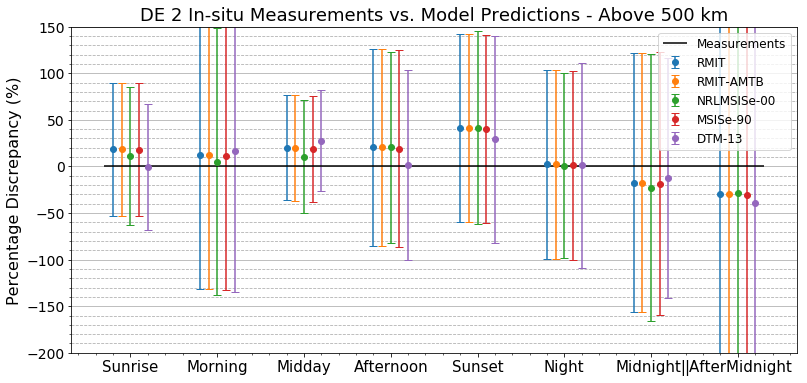

In [44]:
cond_list = [cond_sunrise_hi_alt, 
             cond_morning_hi_alt, 
             cond_midday_hi_alt, 
             cond_aftnoon_hi_alt, 
             cond_sunset_hi_alt, 
             cond_night_hi_alt, 
             cond_midnight_hi_alt, 
             cond_aftmidnite_hi_alt]

xlab_list = ['Sunrise','Morning', 'Midday','Afternoon','Sunset','Night','Midnight|','|AfterMidnight']
df_list = [df_RMIT_clean.loc[even_idx_hi_sol], 
           df_RMIT2_clean.loc[even_idx_hi_sol], 
           df_N00_clean.loc[even_idx_hi_sol], 
           df_M90_clean.loc[even_idx_hi_sol], 
           df_D13_clean.loc[even_idx_hi_sol]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - Above 500 km'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

For altitudes above 500 km, the means range from -39 % to 43 % with very large standard deviations ranging from 58 % to 233 %. Such large variations are to be expected from much less reliable data. Based on the figures seen above, the high altitude
measurements are usually much higher than the predictions from any model (by an order of magntiude or more). This may have 
been due to problems with the instruments taking measurements after passing from high density / low altitude locations to
low density / high altitude locations - trapped air / particles may be artificially increasing the density at high altitudes.
At other instances, the instrument measurements seem to be at a noise floor when reaching high altitudes - in these cases the
model predictions are usually larger.

The lowest means are seen after midnight but also with the highest standard deviation - midnight and after midnight are the
only time periods with negative means but also the highest standard deviations. Those closest to 0.0 % are at morning and night while the smallest standard deviation is at midday. Although DTM-2013 does well in many time periods, it is still the worst model during midday and in many cases has the largest standard deviation. 

With standard deviations of 100 % or more, many of the periods especially later in the day have deviations that are an order of magnitude larger than their means. All model at all time periods pass over the 0.0 % line within one standard deviation, thereby making interpretation of the data difficult.

In terms of sample size, all time period and altitude sub-divisions have thousands of data points with midnight
having the smallest bin of 3,280 points. Therefore sample size is not a problem in this case or any prior case.


- **What are the mean and std. for different times of year? (summer, autumn, winter, spring)**
    
Different seasons (based on sun exposure) and different times of year (based on point in Earth's position in solar orbit) 
are two separate concepts and each will be investigated on the accuracy of each model. Let's begin with different times of year
by defining 4 periods:

Period 1: 1 December - 28 Feburary <br>
Period 2: 1 March - 31 May <br>
Period 3: 1 June - 31 August <br>
Period 4: 1 September - 30 November <br>

Earth periapsis (closest approach to the sun) occurs between 2 - 5 January and apoapsis (furthest from sun) between 4 to 7 July.  
Therefore period 1 is closest to the sun and period 3 is furthest.

First create evenly distributed data. Looking at the histogram of all data, we can see that there is a bias towards days at the end of the year:

In [45]:
# Even distributions across DOY:
even_idx_doy = even_dist_sampling(df_RMIT_clean,cond_a,'DOY',no_bins=36)
even_idx_lo_doy = even_dist_sampling(df_RMIT_clean,lo_alt,'DOY',no_bins=36)
even_idx_hi_doy = even_dist_sampling(df_RMIT_clean,hi_alt,'DOY',no_bins=36)

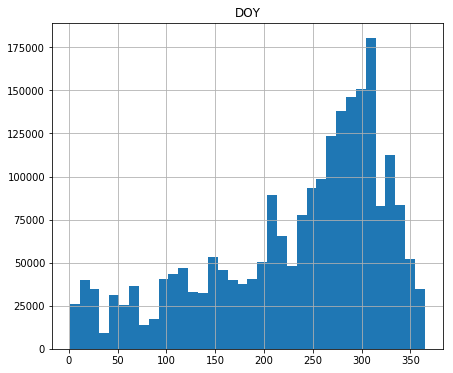

In [46]:
fig2, ax2 = plt.subplots(1,1, figsize=(7,6))
df_RMIT_clean.hist(
    column='DOY',
    bins=36,
    ax=ax2
    )
plt.show(fig2)
plt.close(fig2)

I have used 36 bins in the histogram rather than the usual 60 as I am dealing with a much smaller data range (only 365 possible values rather than the continuous data previously used). Using the even distribution function, relatively evenly distributed data was produced and the resultant histogram can be seen below:

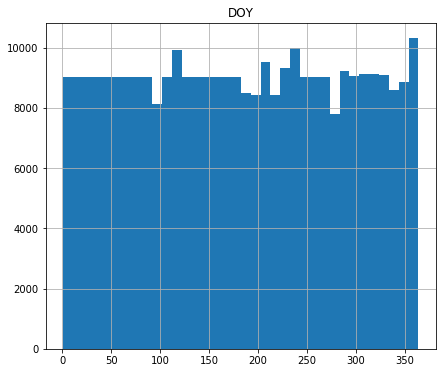

In [47]:
fig2, ax2 = plt.subplots(1,1, figsize=(7,6))
df_RMIT_clean.loc[even_idx_doy].hist(
    column='DOY',
    bins=36,
    ax=ax2
    )
plt.show(fig2)
plt.close(fig2)

In [48]:
# Masks for the four time periods:
cond_1 = (
            (df_RMIT_clean['DOY'].loc[even_idx_doy] >= 335)
            | 
            (df_RMIT_clean['DOY'].loc[even_idx_doy] <= 59)
            )

cond_2 = (
            (df_RMIT_clean['DOY'].loc[even_idx_doy] >= 60) &
            (df_RMIT_clean['DOY'].loc[even_idx_doy] <= 151)
            )
            
cond_3 = (
            (df_RMIT_clean['DOY'].loc[even_idx_doy] >= 152) &
            (df_RMIT_clean['DOY'].loc[even_idx_doy] <= 243)
            )

cond_4 = (
            (df_RMIT_clean['DOY'].loc[even_idx_doy] >= 244) &
            (df_RMIT_clean['DOY'].loc[even_idx_doy] <= 334)
            )

cond_1_lo = (
            (df_RMIT_clean['DOY'].loc[even_idx_lo_doy] >= 335)
            | 
            (df_RMIT_clean['DOY'].loc[even_idx_lo_doy] <= 59)
            )

cond_2_lo = (
            (df_RMIT_clean['DOY'].loc[even_idx_lo_doy] >= 60) &
            (df_RMIT_clean['DOY'].loc[even_idx_lo_doy] <= 151)
            )
            
cond_3_lo = (
            (df_RMIT_clean['DOY'].loc[even_idx_lo_doy] >= 152) &
            (df_RMIT_clean['DOY'].loc[even_idx_lo_doy] <= 243)
            )

cond_4_lo = (
            (df_RMIT_clean['DOY'].loc[even_idx_lo_doy] >= 244) &
            (df_RMIT_clean['DOY'].loc[even_idx_lo_doy] <= 334)
            )

    
cond_1_hi = (
            (df_RMIT_clean['DOY'].loc[even_idx_hi_doy] >= 335)
            | 
            (df_RMIT_clean['DOY'].loc[even_idx_hi_doy] <= 59)
            )

cond_2_hi = (
            (df_RMIT_clean['DOY'].loc[even_idx_hi_doy] >= 60) &
            (df_RMIT_clean['DOY'].loc[even_idx_hi_doy] <= 151)
            )
            
cond_3_hi = (
            (df_RMIT_clean['DOY'].loc[even_idx_hi_doy] >= 152) &
            (df_RMIT_clean['DOY'].loc[even_idx_hi_doy] <= 243)
            )

cond_4_hi = (
            (df_RMIT_clean['DOY'].loc[even_idx_hi_doy] >= 244) &
            (df_RMIT_clean['DOY'].loc[even_idx_hi_doy] <= 334)
            )

#### All Data
<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Period 1</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>14.144 %</td>
      <td>14.112 %</td>
      <td>13.269 %</td>
      <td>13.868 %</td>
      <td>4.718 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>51.71 %</td>
      <td>51.74 %</td>
      <td>51.04 %</td>
      <td>52.15 %</td>
      <td>51.86 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>78297</td>
      <td>78297</td>
      <td>78297</td>
      <td>78297</td>
      <td>78297</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Period 2</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>30.765 %</td>
      <td>30.688 %</td>
      <td>30.156 %</td>
      <td>29.860 %</td>
      <td>31.745 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>104.48 %</td>
      <td>104.49 %</td>
      <td>106.08 %</td>
      <td>104.70 %</td>
      <td>108.44 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>83313</td>
      <td>83313</td>
      <td>83313</td>
      <td>83313</td>
      <td>83313</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Period 3</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>22.024 %</td>
      <td>21.975 %</td>
      <td>22.282 %</td>
      <td>21.322 %</td>
      <td>7.190 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>92.07 %</td>
      <td>92.08 %</td>
      <td>92.97 %</td>
      <td>92.29 %</td>
      <td>101.07 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>81903</td>
      <td>81903</td>
      <td>81903</td>
      <td>81903</td>
      <td>81903</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Period 4</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>21.673 %</td>
      <td>21.608 %</td>
      <td>18.203 %</td>
      <td>21.047 %</td>
      <td>14.137 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>59.93 %</td>
      <td>59.94 %</td>
      <td>59.76 %</td>
      <td>60.02 %</td>
      <td>64.32 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>81171</td>
      <td>81171</td>
      <td>81171</td>
      <td>81171</td>
      <td>81171</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


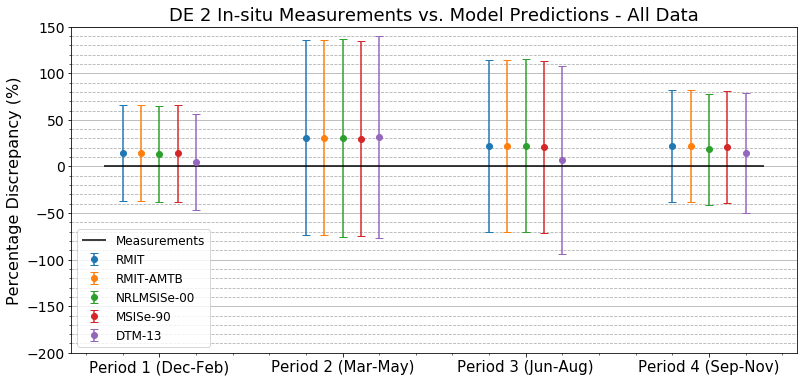

In [49]:
display(Markdown( f'#### All Data'+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_doy],
                   df3 = df_N00_clean.loc[even_idx_doy],
                   df4 = df_M90_clean.loc[even_idx_doy],
                   df5 = df_D13_clean.loc[even_idx_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_1,
                   cond2 = cond_2,
                   var = log_var,
                   condlab1 = 'Period 1',
                   condlab2 = 'Period 2') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_doy],
                   df3 = df_N00_clean.loc[even_idx_doy],
                   df4 = df_M90_clean.loc[even_idx_doy],
                   df5 = df_D13_clean.loc[even_idx_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_3,
                   cond2 = cond_4,
                   var = log_var,
                   condlab1 = 'Period 3',
                   condlab2 = 'Period 4'))) 

cond_list = [cond_1, 
             cond_2, 
             cond_3, 
             cond_4]

xlab_list = ['Period 1 (Dec-Feb)','Period 2 (Mar-May)', 'Period 3 (Jun-Aug)','Period 4 (Sep-Nov)']
df_list = [df_RMIT_clean.loc[even_idx_doy], 
           df_RMIT2_clean.loc[even_idx_doy], 
           df_N00_clean.loc[even_idx_doy], 
           df_M90_clean.loc[even_idx_doy], 
           df_D13_clean.loc[even_idx_doy]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - All Data'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

A similar trend to those of previous sections is seen here in the case of dividing up the data based on the time period. There is no model that does best in terms of mean on every single time period, but DTM-2013 comes close. In period 2, DTM-2013 is the worst model but only by about 2% from MSISe-90 (the best at that time). In every other period, DTM-2013 is closest to 0.0 % by at least 4 % (in Period 4) and up to 14 % (in Period 3). 

The standard deviatio is greatest in period 2 and 3, a litle over and under 100 %. All models pass over the 0.0 % line within one standard deviation.

#### Below 500 km
<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Period 1</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>24.291 %</td>
      <td>24.269 %</td>
      <td>22.907 %</td>
      <td>24.119 %</td>
      <td>13.525 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>18.84 %</td>
      <td>18.84 %</td>
      <td>17.62 %</td>
      <td>18.83 %</td>
      <td>18.49 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>75890</td>
      <td>75890</td>
      <td>75890</td>
      <td>75890</td>
      <td>75890</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Period 2</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>40.814 %</td>
      <td>40.775 %</td>
      <td>42.302 %</td>
      <td>40.501 %</td>
      <td>40.258 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>85.64 %</td>
      <td>85.66 %</td>
      <td>85.76 %</td>
      <td>85.71 %</td>
      <td>95.66 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>81081</td>
      <td>81081</td>
      <td>81081</td>
      <td>81081</td>
      <td>81081</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Period 3</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>41.252 %</td>
      <td>41.218 %</td>
      <td>42.341 %</td>
      <td>40.947 %</td>
      <td>25.313 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>23.88 %</td>
      <td>23.89 %</td>
      <td>23.54 %</td>
      <td>23.94 %</td>
      <td>35.94 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>80332</td>
      <td>80332</td>
      <td>80332</td>
      <td>80332</td>
      <td>80332</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Period 4</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>30.412 %</td>
      <td>30.368 %</td>
      <td>28.348 %</td>
      <td>30.129 %</td>
      <td>19.482 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>20.20 %</td>
      <td>20.20 %</td>
      <td>19.63 %</td>
      <td>20.20 %</td>
      <td>26.08 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>79101</td>
      <td>79101</td>
      <td>79101</td>
      <td>79101</td>
      <td>79101</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


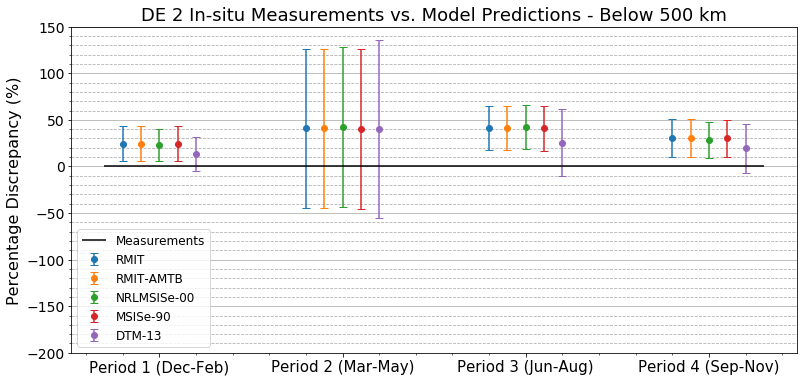

In [50]:
display(Markdown( f'#### Below 500 km'+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_doy],
                   df3 = df_N00_clean.loc[even_idx_lo_doy],
                   df4 = df_M90_clean.loc[even_idx_lo_doy],
                   df5 = df_D13_clean.loc[even_idx_lo_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_1_lo,
                   cond2 = cond_2_lo,
                   var = log_var,
                   condlab1 = 'Period 1',
                   condlab2 = 'Period 2') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_doy],
                   df3 = df_N00_clean.loc[even_idx_lo_doy],
                   df4 = df_M90_clean.loc[even_idx_lo_doy],
                   df5 = df_D13_clean.loc[even_idx_lo_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_3_lo,
                   cond2 = cond_4_lo,
                   var = log_var,
                   condlab1 = 'Period 3',
                   condlab2 = 'Period 4'))) 

cond_list = [cond_1_lo, 
             cond_2_lo, 
             cond_3_lo, 
             cond_4_lo]
xlab_list = ['Period 1 (Dec-Feb)','Period 2 (Mar-May)', 'Period 3 (Jun-Aug)','Period 4 (Sep-Nov)']
df_list = [df_RMIT_clean.loc[even_idx_lo_doy], 
           df_RMIT2_clean.loc[even_idx_lo_doy], 
           df_N00_clean.loc[even_idx_lo_doy], 
           df_M90_clean.loc[even_idx_lo_doy], 
           df_D13_clean.loc[even_idx_lo_doy]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - Below 500 km'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

The more reliable data below 500 km shows yet again a marked decrease in the standard deviation for each time period (with the exception of period 2). In period 2 the standard deviation has fallen by less than 20 % compared to the "All Data" case. For the other time periods standard deviation drops by more than 30 %, with all models apart from the DTM-2013 above the 0.0 % line by more than one standard deviation. This therefore shows the general over estimation of the atmospheric mass density of the models.

Although the DTM-2013 model has its mean closest to 0.0 % in all cases apart from period 2, it does also generally have the greatest standard deviation of all models (except in period 1 where the RMIT and MSIS models have larger deviations). The very large standard deviations in period 2 may suggest that this data is not as reliable - possible interference or instrument errors may have occurred at this point in time. Looking back at the original histogram of the DOY distribution, there are few points to choose from to create the evenly distributed samples which we have used to calculated mean and standard deviation. This may be reflective of problems in gathering data.

#### Above 500 km
<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Period 1</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>-23.966 %</td>
      <td>-24.035 %</td>
      <td>-23.308 %</td>
      <td>-24.563 %</td>
      <td>-24.634 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>122.75 %</td>
      <td>122.77 %</td>
      <td>122.94 %</td>
      <td>123.92 %</td>
      <td>133.85 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>13928</td>
      <td>13928</td>
      <td>13928</td>
      <td>13928</td>
      <td>13928</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Period 2</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>16.773 %</td>
      <td>16.629 %</td>
      <td>13.658 %</td>
      <td>15.090 %</td>
      <td>18.863 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>122.62 %</td>
      <td>122.57 %</td>
      <td>124.52 %</td>
      <td>122.47 %</td>
      <td>117.46 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>36886</td>
      <td>36886</td>
      <td>36886</td>
      <td>36886</td>
      <td>36886</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Period 3</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>-1.040 %</td>
      <td>-1.104 %</td>
      <td>-1.710 %</td>
      <td>-2.198 %</td>
      <td>-11.870 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>158.37 %</td>
      <td>158.34 %</td>
      <td>159.30 %</td>
      <td>158.17 %</td>
      <td>168.80 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>36929</td>
      <td>36929</td>
      <td>36929</td>
      <td>36929</td>
      <td>36929</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Period 4</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>10.031 %</td>
      <td>9.940 %</td>
      <td>4.428 %</td>
      <td>8.947 %</td>
      <td>6.195 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>99.40 %</td>
      <td>99.41 %</td>
      <td>97.83 %</td>
      <td>99.30 %</td>
      <td>106.87 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>35089</td>
      <td>35089</td>
      <td>35089</td>
      <td>35089</td>
      <td>35089</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


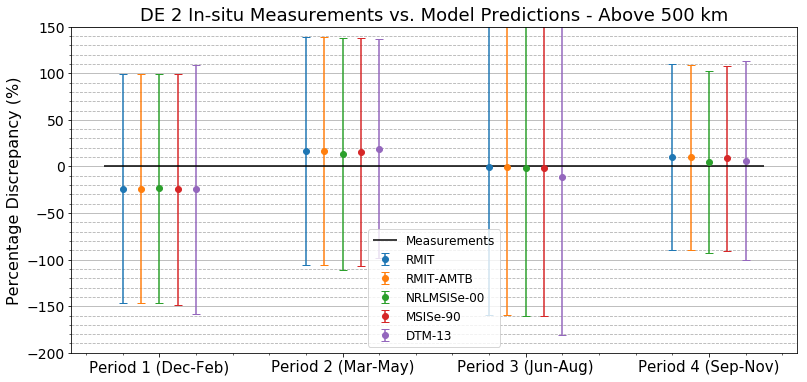

In [51]:
display(Markdown( f'#### Above 500 km'+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_doy],
                   df3 = df_N00_clean.loc[even_idx_hi_doy],
                   df4 = df_M90_clean.loc[even_idx_hi_doy],
                   df5 = df_D13_clean.loc[even_idx_hi_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_1_hi,
                   cond2 = cond_2_hi,
                   var = log_var,
                   condlab1 = 'Period 1',
                   condlab2 = 'Period 2') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_doy],
                   df3 = df_N00_clean.loc[even_idx_hi_doy],
                   df4 = df_M90_clean.loc[even_idx_hi_doy],
                   df5 = df_D13_clean.loc[even_idx_hi_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_3_hi,
                   cond2 = cond_4_hi,
                   var = log_var,
                   condlab1 = 'Period 3',
                   condlab2 = 'Period 4'))) 

cond_list = [cond_1_hi, 
             cond_2_hi, 
             cond_3_hi, 
             cond_4_hi]

xlab_list = ['Period 1 (Dec-Feb)','Period 2 (Mar-May)', 'Period 3 (Jun-Aug)','Period 4 (Sep-Nov)']
df_list = [df_RMIT_clean.loc[even_idx_hi_doy], 
           df_RMIT2_clean.loc[even_idx_hi_doy], 
           df_N00_clean.loc[even_idx_hi_doy], 
           df_M90_clean.loc[even_idx_hi_doy], 
           df_D13_clean.loc[even_idx_hi_doy]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - Above 500 km'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

For the sample above 500 km, we can see that the very high standard deviations continue on from the previous variables that we have looked (latitude, time-of-day). This ranges from under under 100 % to over 160 %. The means are mostly pretty close to the 0.0 % line for all models, except in period 1 where quite uncharacteristically the models on average underestimate the density. The smallest sample size is for period 1 where 13,900 points are present, compared to 35,000 - 37,000 for the other three time periods. Unfortunately there are no data points very close to the beginning and end of the year, so when evenly distributing among 36 bins there may be a roughly even distribution, the edge cases of the periods favour the other time periods rather than time period 1.
                                                                       
Of the four periods, period 1 has the lowest mean for each dataset, in general. When looking at all data, and data below 500 km only, it also has the lowest standard deviation albeit with a larger standard deviation. Therefore, the period that includes the closest approach to the sun also has model prediction results closest to the measurements. Ignoring the problematic Period 2 (which seems to have high standard deviation across the three datasets - All data, data less than and data greater than 500 km), Period 3 has the largest means for all data and for data below 500 km. Period 3 above 500 km is the only period where the RMIT models do better than all others. Below 500 km the mean is over 40 % for all models apart from DTM-2013 and the models are overestimating the measurements in this case. Period 3 is at apoapsis, or the furthest point away from the sun. 

To investigate any seasonal effects, we must not only look at the time of year but also the latitude. For latitudes above 0,
the seasons cycle through as Winter, Spring, Summer, Autumn from Periods 1-4, while for latitudes below 0 they cycle as 
Summer, Autumn, Winter, Spring.

In [52]:
cond_summ = (cond_1&(df_RMIT_clean['Latitude'].loc[even_idx_doy] < 0))|(cond_3&(df_RMIT_clean['Latitude'].loc[even_idx_doy] > 0))
cond_autu = (cond_2&(df_RMIT_clean['Latitude'].loc[even_idx_doy] < 0))|(cond_4&(df_RMIT_clean['Latitude'].loc[even_idx_doy] > 0))
cond_wint = (cond_3&(df_RMIT_clean['Latitude'].loc[even_idx_doy] < 0))|(cond_1&(df_RMIT_clean['Latitude'].loc[even_idx_doy] > 0))
cond_spri = (cond_4&(df_RMIT_clean['Latitude'].loc[even_idx_doy] < 0))|(cond_2&(df_RMIT_clean['Latitude'].loc[even_idx_doy] > 0))


cond_summ_lo = (cond_1_lo&(df_RMIT_clean['Latitude'].loc[even_idx_lo_doy] < 0))|(cond_3_lo&(df_RMIT_clean['Latitude'].loc[even_idx_lo_doy] > 0))
cond_autu_lo = (cond_2_lo&(df_RMIT_clean['Latitude'].loc[even_idx_lo_doy] < 0))|(cond_4_lo&(df_RMIT_clean['Latitude'].loc[even_idx_lo_doy] > 0))
cond_wint_lo = (cond_3_lo&(df_RMIT_clean['Latitude'].loc[even_idx_lo_doy] < 0))|(cond_1_lo&(df_RMIT_clean['Latitude'].loc[even_idx_lo_doy] > 0))
cond_spri_lo = (cond_4_lo&(df_RMIT_clean['Latitude'].loc[even_idx_lo_doy] < 0))|(cond_2_lo&(df_RMIT_clean['Latitude'].loc[even_idx_lo_doy] > 0))


cond_summ_hi = (cond_1_hi&(df_RMIT_clean['Latitude'].loc[even_idx_hi_doy] < 0))|(cond_3_hi&(df_RMIT_clean['Latitude'].loc[even_idx_hi_doy] > 0))
cond_autu_hi = (cond_2_hi&(df_RMIT_clean['Latitude'].loc[even_idx_hi_doy] < 0))|(cond_4_hi&(df_RMIT_clean['Latitude'].loc[even_idx_hi_doy] > 0))
cond_wint_hi = (cond_3_hi&(df_RMIT_clean['Latitude'].loc[even_idx_hi_doy] < 0))|(cond_1_hi&(df_RMIT_clean['Latitude'].loc[even_idx_hi_doy] > 0))
cond_spri_hi = (cond_4_hi&(df_RMIT_clean['Latitude'].loc[even_idx_hi_doy] < 0))|(cond_2_hi&(df_RMIT_clean['Latitude'].loc[even_idx_hi_doy] > 0))

#### All Data
<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Summer</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>20.339 %</td>
      <td>20.281 %</td>
      <td>20.608 %</td>
      <td>19.803 %</td>
      <td>16.672 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>47.54 %</td>
      <td>47.55 %</td>
      <td>45.84 %</td>
      <td>47.81 %</td>
      <td>52.58 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>77566</td>
      <td>77566</td>
      <td>77566</td>
      <td>77566</td>
      <td>77566</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Autumn</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>17.795 %</td>
      <td>17.737 %</td>
      <td>15.166 %</td>
      <td>17.086 %</td>
      <td>14.823 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>75.51 %</td>
      <td>75.50 %</td>
      <td>76.43 %</td>
      <td>75.64 %</td>
      <td>79.38 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>82114</td>
      <td>82114</td>
      <td>82114</td>
      <td>82114</td>
      <td>82114</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Winter</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>16.049 %</td>
      <td>16.025 %</td>
      <td>15.206 %</td>
      <td>15.607 %</td>
      <td>-3.172 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>95.06 %</td>
      <td>95.08 %</td>
      <td>96.69 %</td>
      <td>95.38 %</td>
      <td>97.73 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>82634</td>
      <td>82634</td>
      <td>82634</td>
      <td>82634</td>
      <td>82634</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Spring</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>35.168 %</td>
      <td>35.083 %</td>
      <td>33.726 %</td>
      <td>34.348 %</td>
      <td>31.178 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>90.08 %</td>
      <td>90.11 %</td>
      <td>90.79 %</td>
      <td>90.25 %</td>
      <td>95.56 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>82366</td>
      <td>82366</td>
      <td>82366</td>
      <td>82366</td>
      <td>82366</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


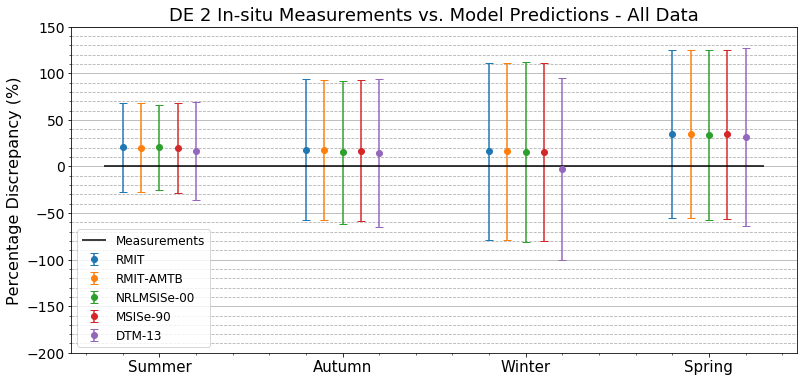

In [53]:
display(Markdown( f'#### All Data'+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_doy],
                   df3 = df_N00_clean.loc[even_idx_doy],
                   df4 = df_M90_clean.loc[even_idx_doy],
                   df5 = df_D13_clean.loc[even_idx_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_summ,
                   cond2 = cond_autu,
                   var = log_var,
                   condlab1 = 'Summer',
                   condlab2 = 'Autumn') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_doy],
                   df3 = df_N00_clean.loc[even_idx_doy],
                   df4 = df_M90_clean.loc[even_idx_doy],
                   df5 = df_D13_clean.loc[even_idx_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_wint,
                   cond2 = cond_spri,
                   var = log_var,
                   condlab1 = 'Winter',
                   condlab2 = 'Spring'))) 

cond_list = [cond_summ, 
             cond_autu, 
             cond_wint, 
             cond_spri]

xlab_list = ['Summer','Autumn', 'Winter','Spring']
df_list = [df_RMIT_clean.loc[even_idx_doy], 
           df_RMIT2_clean.loc[even_idx_doy], 
           df_N00_clean.loc[even_idx_doy], 
           df_M90_clean.loc[even_idx_doy], 
           df_D13_clean.loc[even_idx_doy]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - All Data'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

#### Below 500 km
<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Summer</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>31.983 %</td>
      <td>31.944 %</td>
      <td>31.661 %</td>
      <td>31.719 %</td>
      <td>27.368 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>22.51 %</td>
      <td>22.52 %</td>
      <td>21.60 %</td>
      <td>22.55 %</td>
      <td>32.45 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>80173</td>
      <td>80173</td>
      <td>80173</td>
      <td>80173</td>
      <td>80173</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Autumn</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>24.775 %</td>
      <td>24.743 %</td>
      <td>24.532 %</td>
      <td>24.504 %</td>
      <td>17.304 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>21.15 %</td>
      <td>21.15 %</td>
      <td>20.25 %</td>
      <td>21.14 %</td>
      <td>25.94 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>77562</td>
      <td>77562</td>
      <td>77562</td>
      <td>77562</td>
      <td>77562</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Winter</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>33.547 %</td>
      <td>33.530 %</td>
      <td>33.481 %</td>
      <td>33.338 %</td>
      <td>11.618 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>23.06 %</td>
      <td>23.06 %</td>
      <td>23.38 %</td>
      <td>23.05 %</td>
      <td>22.48 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>76047</td>
      <td>76047</td>
      <td>76047</td>
      <td>76047</td>
      <td>76047</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Spring</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>46.569 %</td>
      <td>46.517 %</td>
      <td>46.111 %</td>
      <td>46.243 %</td>
      <td>42.276 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>82.78 %</td>
      <td>82.80 %</td>
      <td>83.42 %</td>
      <td>82.85 %</td>
      <td>93.83 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>82618</td>
      <td>82618</td>
      <td>82618</td>
      <td>82618</td>
      <td>82618</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


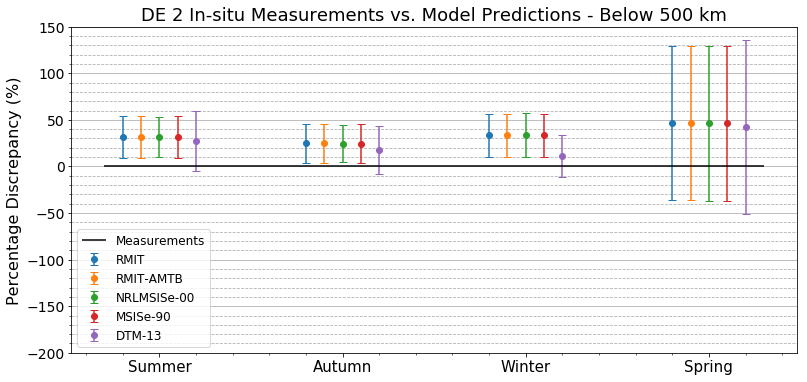

In [54]:
display(Markdown( f'#### Below 500 km'+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_doy],
                   df3 = df_N00_clean.loc[even_idx_lo_doy],
                   df4 = df_M90_clean.loc[even_idx_lo_doy],
                   df5 = df_D13_clean.loc[even_idx_lo_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_summ_lo,
                   cond2 = cond_autu_lo,
                   var = log_var,
                   condlab1 = 'Summer',
                   condlab2 = 'Autumn') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_lo_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_lo_doy],
                   df3 = df_N00_clean.loc[even_idx_lo_doy],
                   df4 = df_M90_clean.loc[even_idx_lo_doy],
                   df5 = df_D13_clean.loc[even_idx_lo_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_wint_lo,
                   cond2 = cond_spri_lo,
                   var = log_var,
                   condlab1 = 'Winter',
                   condlab2 = 'Spring'))) 

cond_list = [cond_summ_lo, 
             cond_autu_lo, 
             cond_wint_lo, 
             cond_spri_lo]

xlab_list = ['Summer','Autumn', 'Winter','Spring']
df_list = [df_RMIT_clean.loc[even_idx_lo_doy], 
           df_RMIT2_clean.loc[even_idx_lo_doy], 
           df_N00_clean.loc[even_idx_lo_doy], 
           df_M90_clean.loc[even_idx_lo_doy], 
           df_D13_clean.loc[even_idx_lo_doy]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - Below 500 km'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

#### Above 500 km
<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Summer</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>-1.634 %</td>
      <td>-1.731 %</td>
      <td>0.141 %</td>
      <td>-2.714 %</td>
      <td>-0.225 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>84.85 %</td>
      <td>84.81 %</td>
      <td>82.20 %</td>
      <td>84.91 %</td>
      <td>88.12 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>26958</td>
      <td>26958</td>
      <td>26958</td>
      <td>26958</td>
      <td>26958</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Autumn</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>9.480 %</td>
      <td>9.384 %</td>
      <td>3.376 %</td>
      <td>8.213 %</td>
      <td>12.499 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>129.61 %</td>
      <td>129.58 %</td>
      <td>130.13 %</td>
      <td>129.61 %</td>
      <td>137.20 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>36991</td>
      <td>36991</td>
      <td>36991</td>
      <td>36991</td>
      <td>36991</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>

<table>
<tr>
<td align="center">

<table>
  <thead>
    <tr>
      <th>Winter</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>-14.550 %</td>
      <td>-14.587 %</td>
      <td>-16.715 %</td>
      <td>-15.429 %</td>
      <td>-30.060 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>220.86 %</td>
      <td>220.89 %</td>
      <td>223.65 %</td>
      <td>221.06 %</td>
      <td>229.86 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>23899</td>
      <td>23899</td>
      <td>23899</td>
      <td>23899</td>
      <td>23899</td>
    </tr>
  </tbody>
</table>
        
</td><td align="center">

<table>
  <thead>
    <tr>
      <th>Spring</th>
      <th>RMIT</th>
      <th>RMIT-AMTB</th>
      <th>N-00</th>
      <th>M-90</th>
      <th>D-13</th> 
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mean</td>
      <td>17.776 %</td>
      <td>17.634 %</td>
      <td>15.412 %</td>
      <td>16.263 %</td>
      <td>12.519 %</td>
    </tr>
    <tr>
      <td>Std.</td>
      <td>91.41 %</td>
      <td>91.40 %</td>
      <td>91.10 %</td>
      <td>91.12 %</td>
      <td>85.83 %</td>
    </tr>
    <tr>
      <td>No. Pts</td>
      <td>34983</td>
      <td>34983</td>
      <td>34983</td>
      <td>34983</td>
      <td>34983</td>
    </tr>
  </tbody>
</table>
        
</td>
</tr> 
</table>


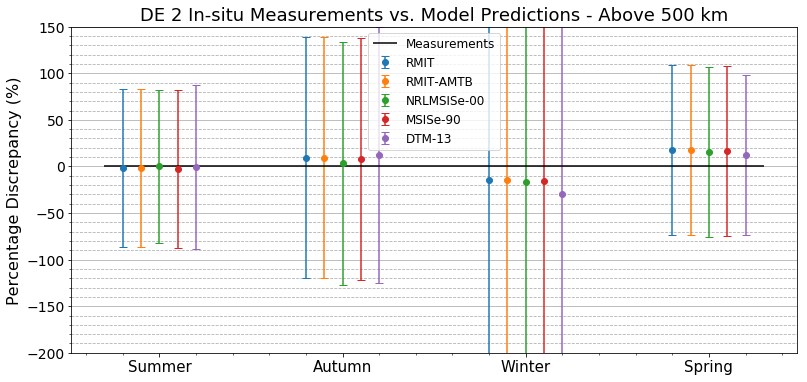

In [55]:
display(Markdown( f'#### Above 500 km'+
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_doy],
                   df3 = df_N00_clean.loc[even_idx_hi_doy],
                   df4 = df_M90_clean.loc[even_idx_hi_doy],
                   df5 = df_D13_clean.loc[even_idx_hi_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_summ_hi,
                   cond2 = cond_autu_hi,
                   var = log_var,
                   condlab1 = 'Summer',
                   condlab2 = 'Autumn') + 
                create_2cond_table(df1 = df_RMIT_clean.loc[even_idx_hi_doy],
                   df2 = df_RMIT2_clean.loc[even_idx_hi_doy],
                   df3 = df_N00_clean.loc[even_idx_hi_doy],
                   df4 = df_M90_clean.loc[even_idx_hi_doy],
                   df5 = df_D13_clean.loc[even_idx_hi_doy],
                   modlab1 = 'RMIT',
                   modlab2 = 'RMIT-AMTB',
                   modlab3 = 'N-00',
                   modlab4 = 'M-90',
                   modlab5 = 'D-13',
                   cond1 = cond_wint_hi,
                   cond2 = cond_spri_hi,
                   var = log_var,
                   condlab1 = 'Winter',
                   condlab2 = 'Spring'))) 

cond_list = [cond_summ_hi, 
             cond_autu_hi, 
             cond_wint_hi, 
             cond_spri_hi]

xlab_list = ['Summer','Autumn', 'Winter','Spring']
df_list = [df_RMIT_clean.loc[even_idx_hi_doy], 
           df_RMIT2_clean.loc[even_idx_hi_doy], 
           df_N00_clean.loc[even_idx_hi_doy], 
           df_M90_clean.loc[even_idx_hi_doy], 
           df_D13_clean.loc[even_idx_hi_doy]]
title_str = 'DE 2 In-situ Measurements vs. Model Predictions - Above 500 km'

all_fig = compare_dots_plot(df_list,model_list,cond_list,var,title_str, xlab_list)
plt.show(all_fig)
plt.close(all_fig)

Looking at all the data, the season in which the measurements are taken does not seem to affect the mean discrepancy too much, with ranges of 15 - 35 %, with all models similar in each period except Winter where DTM-2013 is closest by over 10 %. However, the winter period is slightly more variable in the standard deviation. 

Comparing against the low altitude data, the models have a significantly lower standard deviation except for during the Spring period. The standard deviation in Spring actually only drops by single digit percentage points to just above 80 %, whereas the other periods have a drop to low 20 %. The DTM-2013 model again has the closest mean to 0.0 % in each period, which is most significant in Winter, being over 20 % closer to 0.0 % for all the other model.

At high altitudes, as expected the standard deviations are very large getting to as high as over 230 % during the Winter period. Interestingly Winter is also the only period where the RMIT models outperform all others, with a mean closest to the 0.0 % line. It is also the only case in all that we have investigated so far where this is true as well. However, with such a large standard deviation the significance of the proximity to the 0.0 % line is questionable. In the Summer and Autumn periods the NRLMSISe-00 model's mean is closest to 0.0 % while DTM-2013 is closest in Spring.

### Discussion / Conclusion

The results above reveal some of the issues with the DE2 data but also reveals a clear model leader in proximity to this empirical data. The DTM-2013 model

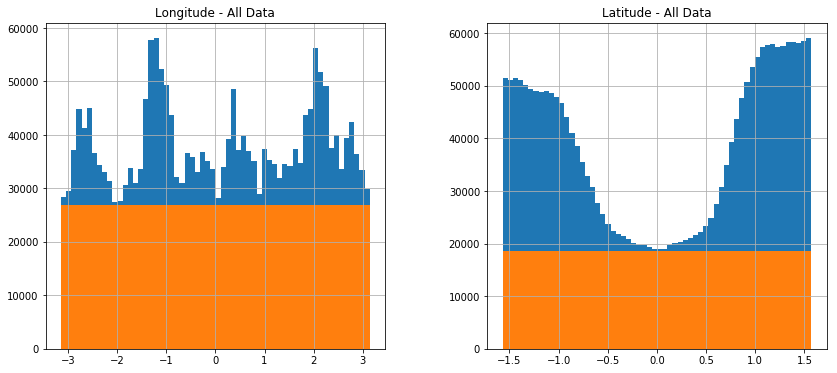

In [57]:
fig1, ax1 = plt.subplots(1,2, figsize=(14,6)) # ,sharex='col', sharey='row')
df_RMIT_clean.hist(
    column='Longitude',
    bins=60, 
    ax=ax1[0]
    #density=True
    )

df_RMIT_clean.hist(
    column='Latitude',
    bins=60, 
    ax=ax1[1]
    #density=True,
    )


df_RMIT_clean.loc[even_idx_long].hist(
    column='Longitude',
    bins=60, 
    ax=ax1[0]
    #density=True
    )

df_RMIT_clean.loc[even_idx_lat].hist(
    column='Latitude',
    bins=60, 
    ax=ax1[1]
    #density=True,
    )


ax1[0].set_title('Longitude - All Data')
ax1[1].set_title('Latitude - All Data')

plt.show(fig1)
plt.close(fig1)

In [58]:
len(df_RMIT_clean)

2274829